Connected to rqnet (Python 3.12.4)

# RQ net

## Libraries

In [1]:
import argparse
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
from os.path import join
from os import listdir
from torch.utils.data import DataLoader
from Network_sep import inv_stn, Net_x
from tictoc import tic, toc
from pathlib import Path
from nmi_loss import normalized_cross_correlation

train_load_directory = './train_demo_data'
test_load_directory = './test_demo_data'

## Trainset and Testset load

In [2]:
class Mytrainset(Dataset):
    def __init__(self):
        super(Mytrainset, self).__init__()
        self.training_filenames = sorted([join(train_load_directory, x) for x in listdir(train_load_directory)])

    def __getitem__(self, index):
        matfile = sio.loadmat(self.training_filenames[index])
        S_invivo = matfile['DWI_motion']
        S_invivo = torch.tensor(S_invivo.astype(np.float32))

        mask_train= matfile['mask_motion']
        mask_train = torch.tensor(mask_train.astype(np.float32))

        S_invivo_original = matfile['DWI_original']
        S_invivo_original = torch.tensor(S_invivo_original.astype(np.float32))

        S_invivo = S_invivo.permute(2, 0, 1) #[batch size, channels, height, width]
        mask_train = mask_train.permute(2, 0, 1) #[batch size, channels, height, width]
        S_invivo_original = S_invivo_original.permute(2,0,1)
        return S_invivo, mask_train, S_invivo_original
    def __len__(self):
        return len(self.training_filenames)
    
class Mytestset(Dataset):
    def __init__(self):
        super(Mytestset, self).__init__()
        self.test_filenames = sorted([join(test_load_directory, x) for x in listdir(test_load_directory)])

    def __getitem__(self, index):
        matfile = sio.loadmat(self.test_filenames[index])
        S_invivo = matfile['DWI_motion']
        S_invivo = torch.tensor(S_invivo.astype(np.float32))

        mask_train= matfile['mask_motion']
        mask_train = torch.tensor(mask_train.astype(np.float32))

        S_invivo_original = matfile['DWI_original']
        S_invivo_original = torch.tensor(S_invivo_original.astype(np.float32))

        S_invivo = S_invivo.permute(2, 0, 1)        #[batch size, channels, height, width]
        mask_train = mask_train.permute(2, 0, 1)    #[batch size, channels, height, width]
        S_invivo_original = S_invivo_original.permute(2,0,1)
        return S_invivo, mask_train, S_invivo_original
    def __len__(self):
        return len(self.test_filenames)

## Hyper parameters

In [7]:
fmin = 0; fmax = 0.4; Dmin = 0; Dmax = 3e-3; Dpmin = 3e-3; Dpmax = 100e-3; Kmin = 0; Kmax = 3.0

num_epochs_train=2000
num_epochs_test=6000
num_bvalue = 15
BATCH_SIZE_TRAIN = 8
NUM_WORKERS = 0
GPU_NUM = 0

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)  # change allocation of current GPU
criterion = nn.MSELoss()

b= torch.tensor([0., 20., 40., 60., 80., 100., 200.,
                    400., 600., 800., 1000.,1300., 1500.,
                    2000.,2400.]).view(1, num_bvalue, 1, 1).to(device)

model = Net_x(num_bvalue)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
quant_optimizer = optim.Adam([
    {'params': model.quant_net.parameters()},
    {'params': model.quant_net_f.parameters()}
], lr=1e-3)


train_loss =[]
train_signal_loss=[]
train_ncc_loss = []

test_loss = []
test_signal_loss = []
test_ncc_loss = []

## Trainset and Testset

In [8]:
trainset = Mytrainset()
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=False, num_workers=0)
testset = Mytestset()
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE_TRAIN, shuffle=False, num_workers=0)

## Training (Already trained and saved in the directory)

In [6]:
# Comments: already trained and saved 
# epochs = tqdm(range(num_epochs_train), desc="Epochs")

# for epoch in epochs:
#     if epoch % 400 == 0:
#         print(epoch)
#     train_batch_loss = []
#     train_signal_batch_loss = []
#     train_ncc_batch_loss = []

#     train_batch_loss = []
#     train_signal_batch_loss = []
#     train_ncc_batch_loss = []

#     for iteration, batch in enumerate(trainloader):
#         S0 = batch[0][:,0,:,:]
#         h=batch[0].size(2)
#         w=batch[0].size(3)
#         mask_train = batch[1]

#         motion_mask = mask_train.to(device)
#         motion_mask = motion_mask.view(-1,num_bvalue,h,w)

#         S0_mask = mask_train[:,0,:,:].view(-1,1,h,w).to(device)
#         S0 = S0.view(-1,1,h,w).to(device) * S0_mask
#         S0_mask_repeat = S0_mask.repeat(1,num_bvalue,1,1).to(device)

#         S_input_n = batch[0]/1000
#         S_input_n[torch.isnan(S_input_n)] = 0
#         S_input_n[torch.isinf(S_input_n)] = 0
#         S_input_n = S_input_n.to(device)
#         S_input_n = S_input_n.view(-1,num_bvalue,h,w)

#         S_input_n_original = batch[2]/1000
#         S_input_n_original[torch.isnan(S_input_n_original)] = 0
#         S_input_n_original[torch.isinf(S_input_n_original)] = 0
#         S_input_n_original = S_input_n_original.to(device)
#         S_input_n_original = S_input_n_original.view(-1,num_bvalue,h,w)

#         # STN + DNN
#         IVIM_map_x, fxyz, theta, rot_S_b1, rot_S_b1_masked = model(S_input_n,  S0_mask_repeat)

#         # f = fxyz[:, 0, :, :].view(-1, 1, h, w)*(fmax-fmin)+fmin
#         f = IVIM_map_x[:, 3, :, :].view(-1, 1, h, w)*(fmax-fmin)+fmin

#         Dx = IVIM_map_x[:, 0, :, :].view(-1, 1, h, w)*(Dmax-Dmin)+Dmin
#         Dpx = IVIM_map_x[:, 1, :, :].view(-1, 1, h, w)*(Dpmax-Dpmin)+Dpmin
#         Kx = IVIM_map_x[:, 2, :, :].view(-1, 1, h, w)*(Kmax-Kmin)+Kmin

#         #Biexponential model
#         S_estimate_x = S0 * (f * torch.exp(-b * Dpx) + (1 - f) * torch.exp(-b * Dx + 1/6*(b**2)*(Dx**2)*Kx)) / 1000
#         S_estimate_x = S_estimate_x.view([-1, num_bvalue, h, w])
#         mask_fixed_train = S0_mask_repeat.view(-1,num_bvalue, h, w)

#         #Inverse STN 
#         S_estimate_inverse, inv_theta = inv_stn(S_estimate_x[:,1:,:,:], theta, device)
#         S_estimate_x = torch.cat((S_input_n[:,0,:,:].view(-1,1,h, w), S_estimate_x[:,1:,:,:]), 1)

#         S_estimate_inverse = S_estimate_inverse.view(-1,(num_bvalue-1),h, w)
#         S_estimate_inverse = torch.cat((S_input_n[:,0,:,:].view(-1,1,h,w), S_estimate_inverse), 1)


#         #LOSS1: Signal LOSS
#         Signal_loss = criterion(S_input_n, S_estimate_inverse)

#         #LOSS2: NMI LOSS
#         # ncc_loss = 0
#         # for bi in range(1, 3*(num_bvalue-1)+1):
#         #     ncc_loss += -torch.log((normalized_cross_correlation(S_input_n[:,0,:,:], rot_S_b1[:,bi,:,:],False)+1)/2)

#         #LOSS3: NCC LOSS
#         ncc_loss_io = 0
#         for bi in range(1, num_bvalue):
#             ncc_loss_io += -torch.log((normalized_cross_correlation(S_input_n[:,bi,:,:], S_estimate_inverse[:,bi,:,:],False)+1)/2)


#         if epoch < num_epochs_train/2:
#             loss = ncc_loss_io + criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)*1000
#             optimizer.zero_grad()
#             loss.backward(retain_graph=True)
#             optimizer.step()
#         else:
#             loss = criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)*1000
#             quant_optimizer.zero_grad()
#             loss.backward(retain_graph=True)
#             quant_optimizer.step()

#         train_batch_loss.append(loss.item())
#         train_signal_batch_loss.append(Signal_loss.item())

#         if epoch % 100 == 0 and iteration == 0:
#             print(f"ncc_loss_io: {ncc_loss_io}")
#             print(f"loss a: {criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)}")
#             print(f"total LOSS: {loss} epoch: {epoch}")
#             plt.plot(train_loss)
        
#             plt.figure(figsize=(16,10))
#             plt.xticks([])
#             plt.yticks([])
#             plt.box(None)
#             b_value = [0, 20,40,60,80,100,200,400,600,800,1000,1300,1500,2000,2400]

#             for i in range(15):
#                 plt.subplot(3,7,i+1)
#                 plt.title('b-value='+str(b_value[i])+' \n s/mm$^{2}$')
#                 plt.imshow(rot_S_b1[0,i,:,:].detach().cpu(),vmin=0,vmax=1,cmap='gray')
#                 plt.xticks([])
#                 plt.yticks([])
#             plt.show()

#             plt.figure(figsize=(16,10))
#             plt.xticks([])
#             plt.yticks([])
#             plt.box(None)
#             plt.subplot(1,4,1)
#             plt.title('f')
#             plt.imshow(f[0,0,:,:].detach().cpu(),vmin=0,vmax=0.3,cmap='gray')
#             plt.subplot(1,4,2)
#             plt.title('Dx')
#             plt.imshow(Dx[0,0,:,:].detach().cpu(),vmin=0,vmax=3e-3,cmap='gray')
#             plt.subplot(1,4,3)
#             plt.title('Dpx')
#             plt.imshow(Dpx[0,0,:,:].detach().cpu(),vmin=0,vmax=50e-3,cmap='gray')
#             plt.subplot(1,4,4)
#             plt.title('Kx')
#             plt.imshow(Kx[0,0,:,:].detach().cpu(),vmin=0,vmax=3,cmap='gray')
#             plt.show()

#     train_loss.append(np.mean(train_batch_loss))
#     train_signal_loss.append(np.mean(train_signal_batch_loss))

# # save trained model
# save_path ='./'
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'quant_optimizer_state_dict': quant_optimizer.state_dict(),
#     'train_loss': train_loss,
# }, save_path+'trained_model.pth')

# save_name = save_path + '/training_results.mat'

# sio.savemat(save_name, {
#                         'mask_train': mask_train.detach().cpu().numpy(),
#                         'theta':theta.detach().cpu().numpy(),

#                         'f': f.detach().cpu().numpy(), 'Dx': Dx.detach().cpu().numpy(),
#                         'Dpx': Dpx.detach().cpu().numpy(),
#                         'Kx': Kx.detach().cpu().numpy(),
#                         'S_input_n': S_input_n.detach().cpu().numpy(),
#                         'rot_S_b1': rot_S_b1.detach().cpu().numpy(),
#                         'S_estimate': S_estimate_x.detach().cpu().numpy(),
#                         'S_estimate_inverse': S_estimate_inverse.detach().cpu().numpy(),
#                         'S_input_n_original': S_input_n_original.detach().cpu().numpy(),

#                         'train_loss': train_loss,
#                         }
#             )

## RQnet for test data

Epochs:   0%|          | 0/6000 [00:00<?, ?it/s]

0


d:\AppData\anaconda3\envs\rqnet\Lib\site-packages\torch\nn\functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
d:\AppData\anaconda3\envs\rqnet\Lib\site-packages\torch\nn\functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


ncc_loss_io: 0.1723477989435196
loss a: 0.00019757293921429664
total LOSS: 0.3699207305908203 epoch: 0


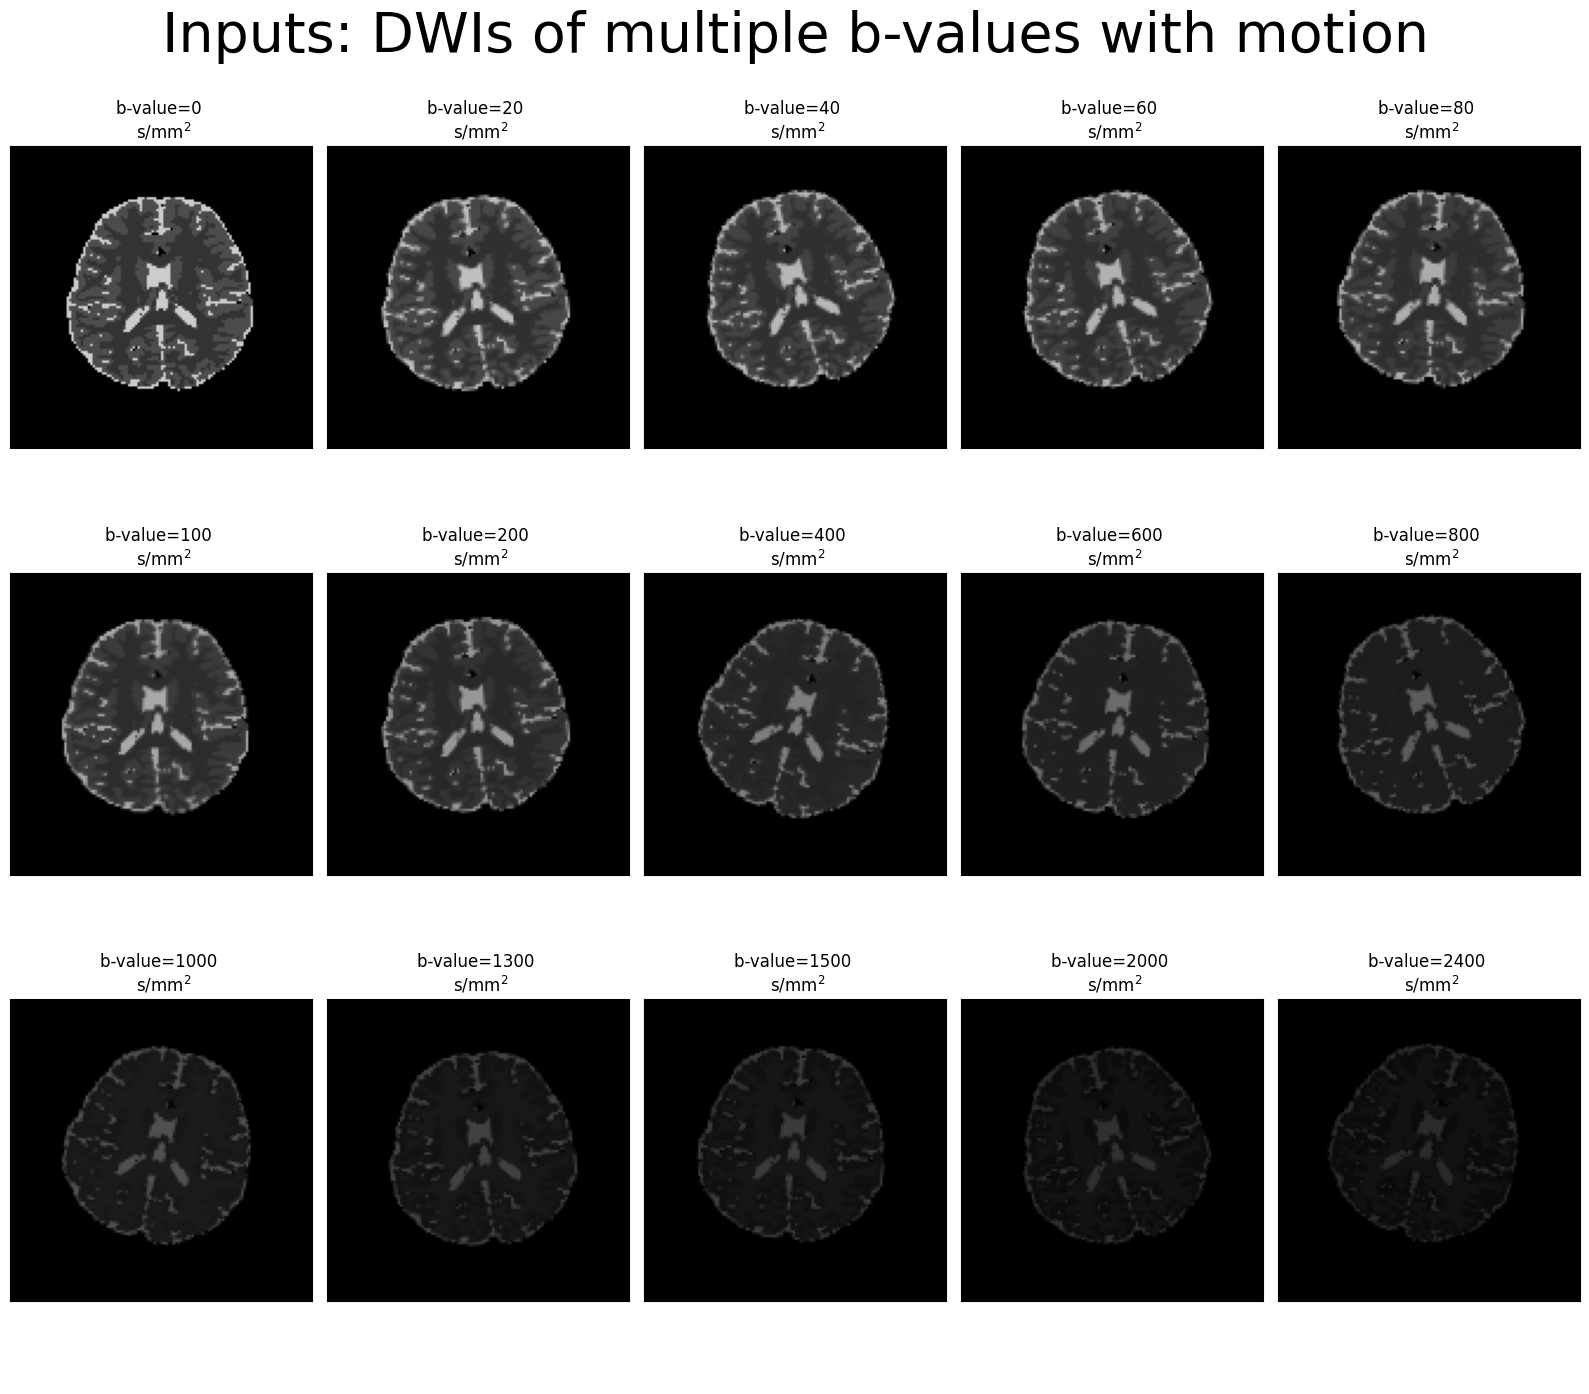

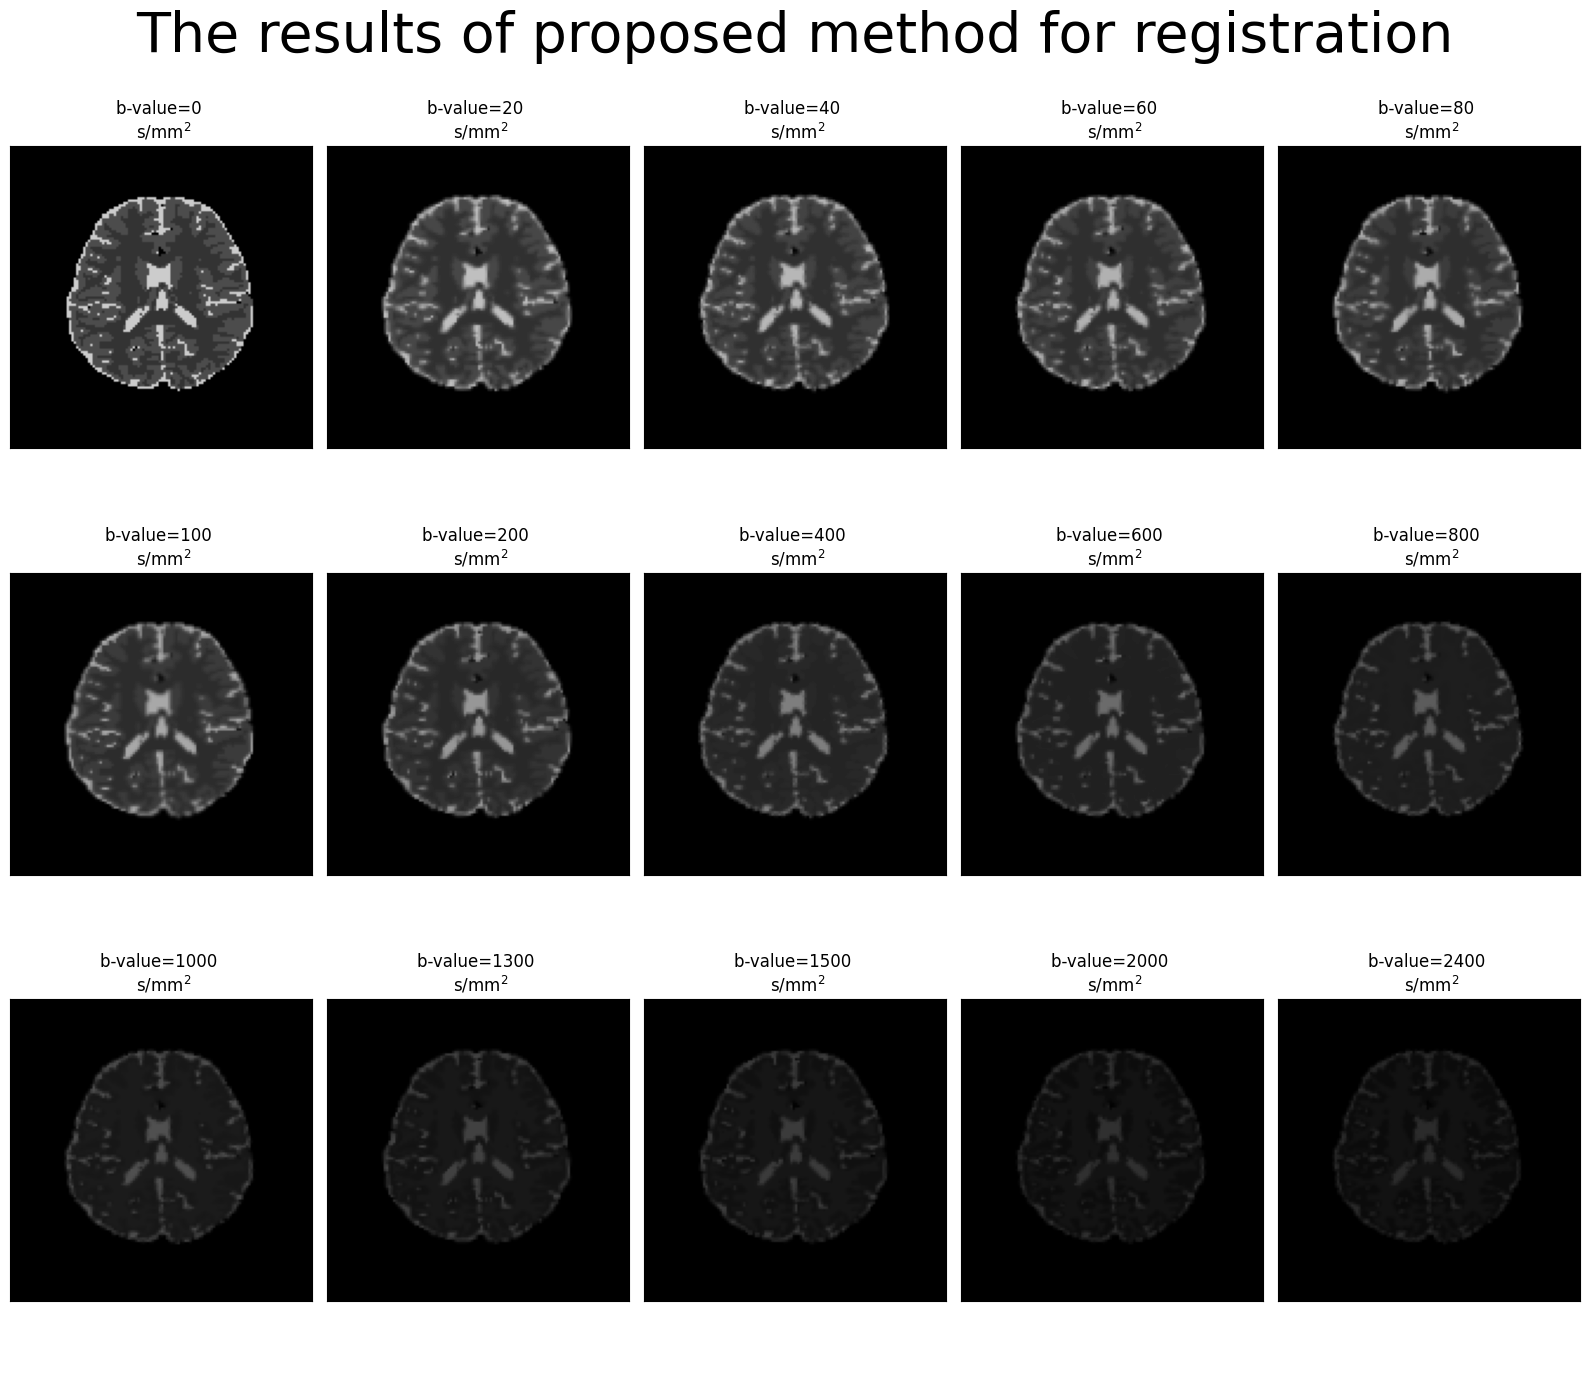

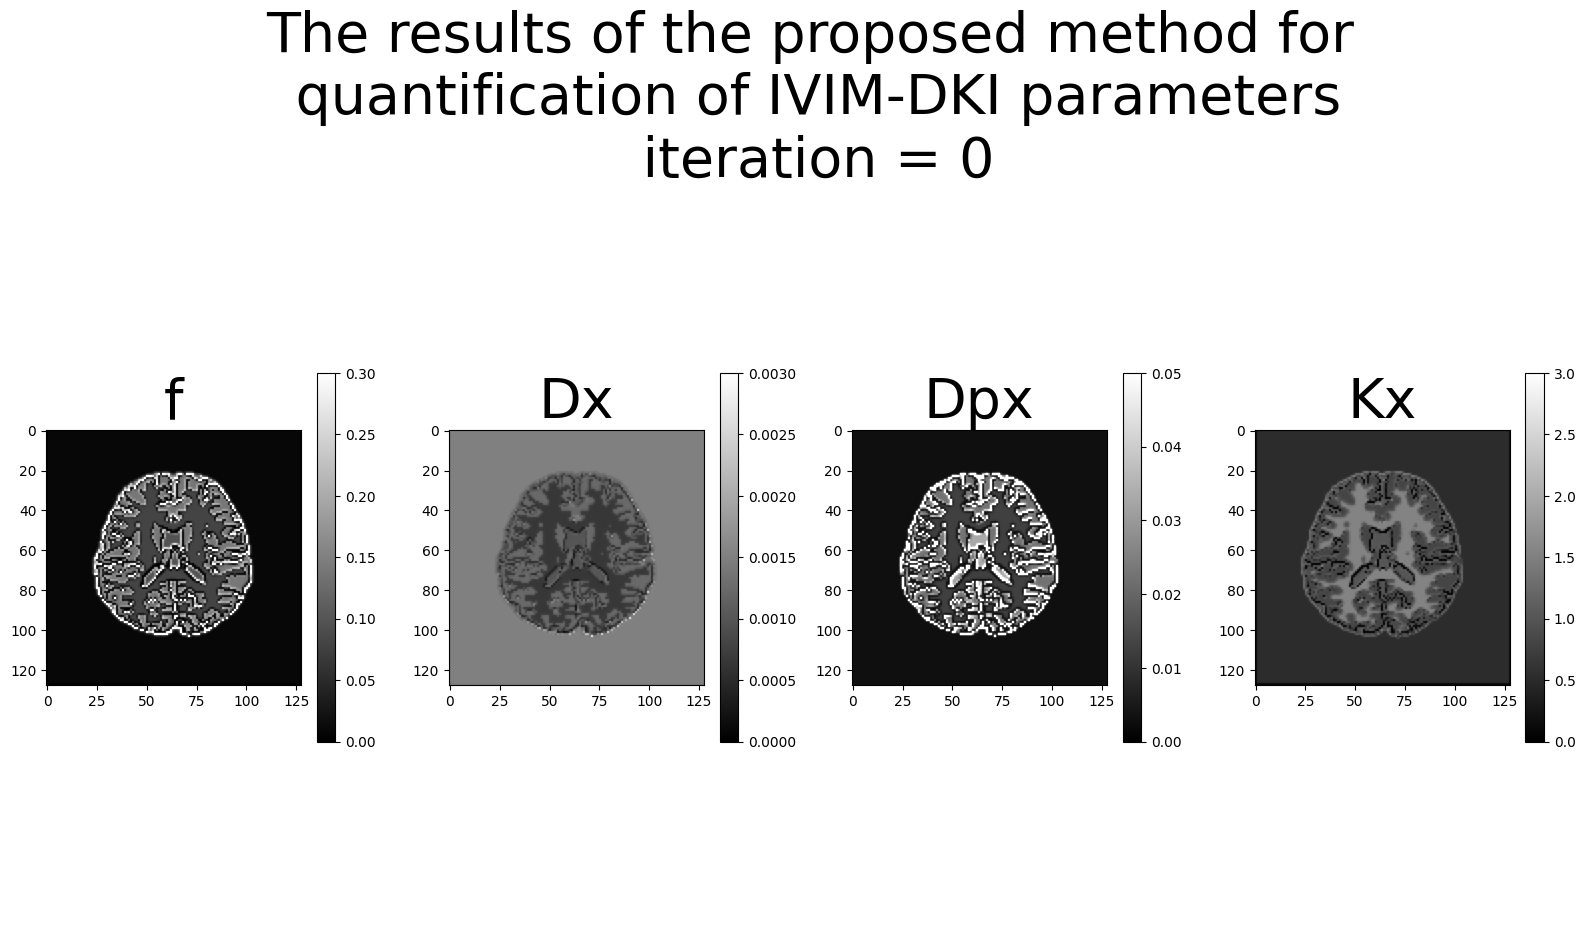

Epochs:   7%|▋         | 403/6000 [00:22<04:27, 20.89it/s]

400


Epochs:  13%|█▎        | 804/6000 [00:43<04:39, 18.62it/s]

800


Epochs:  17%|█▋        | 1000/6000 [00:54<05:15, 15.83it/s]

ncc_loss_io: 0.049800604581832886
loss a: 0.0001240564597537741
total LOSS: 0.17385706305503845 epoch: 1000


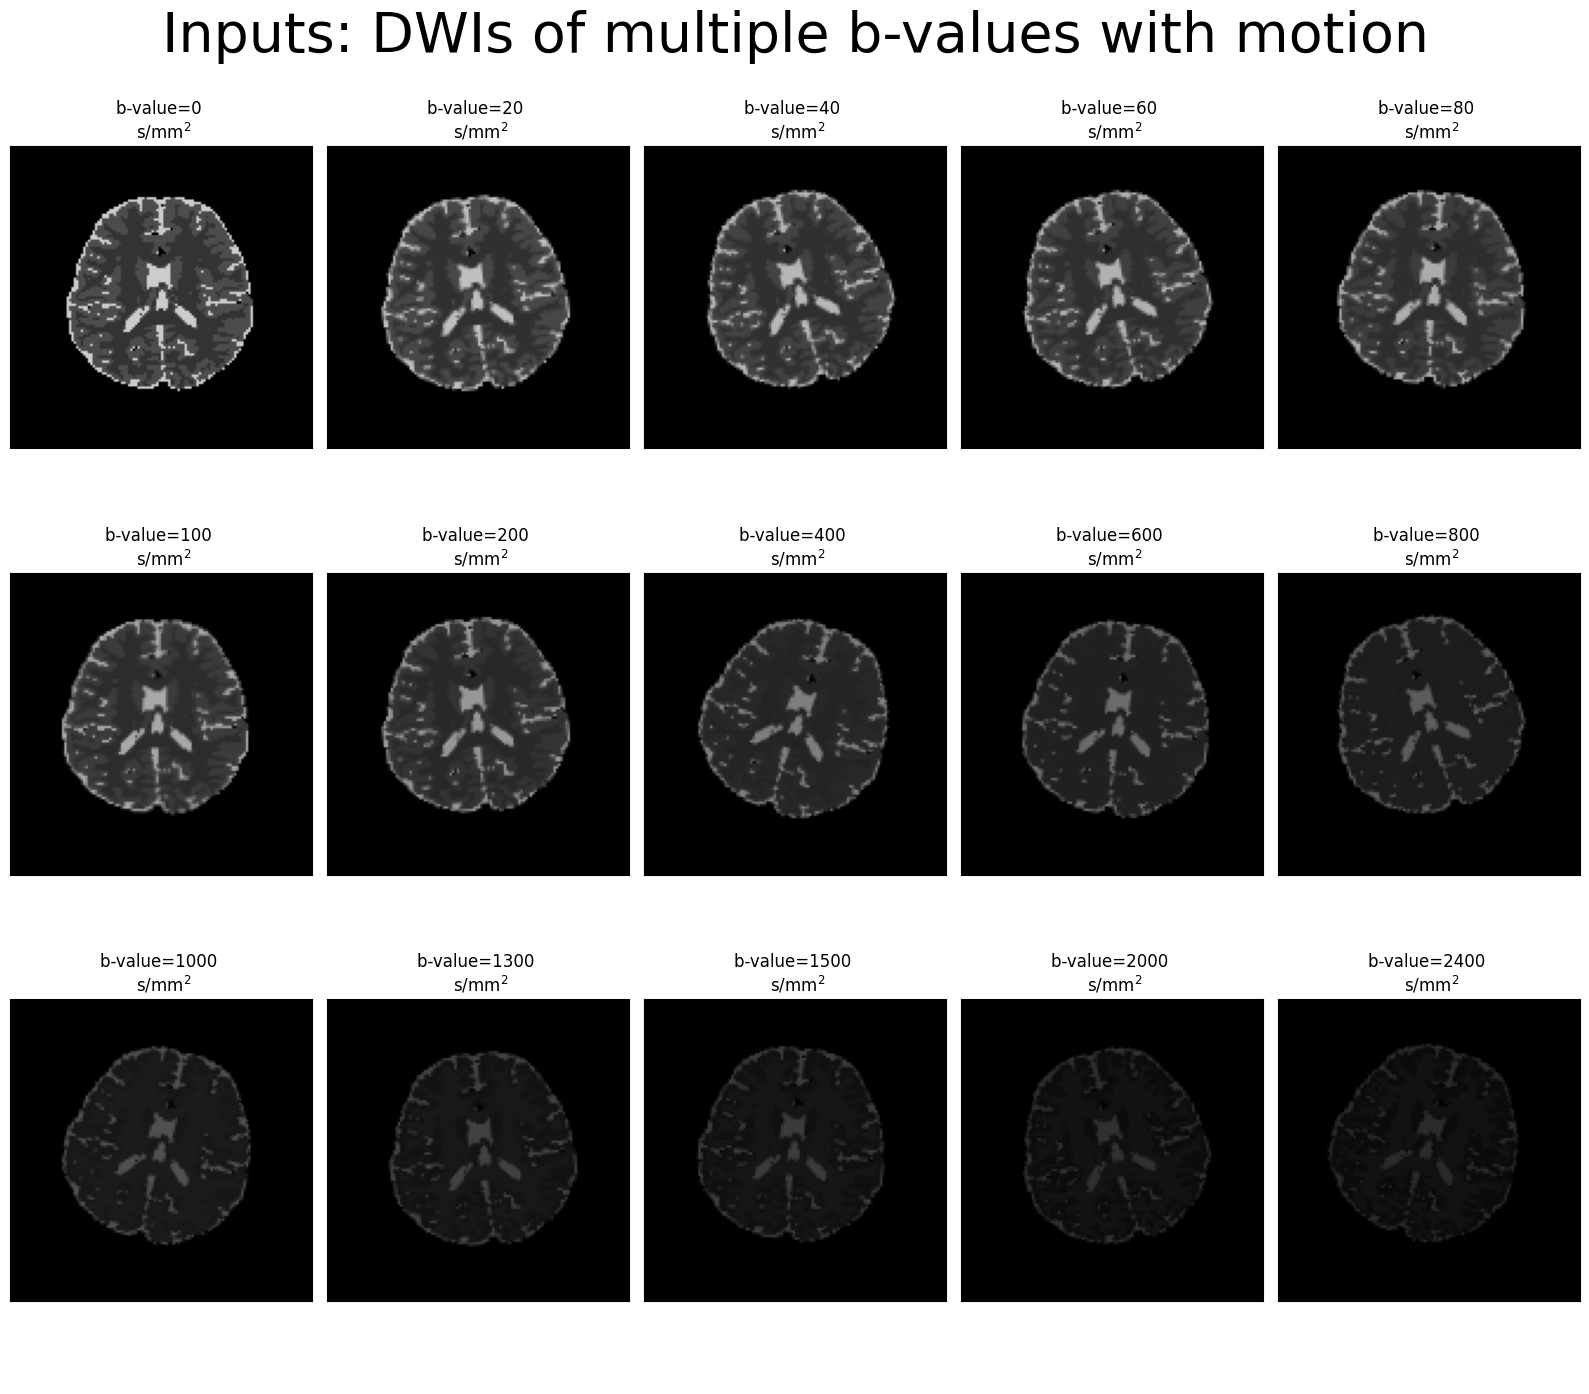

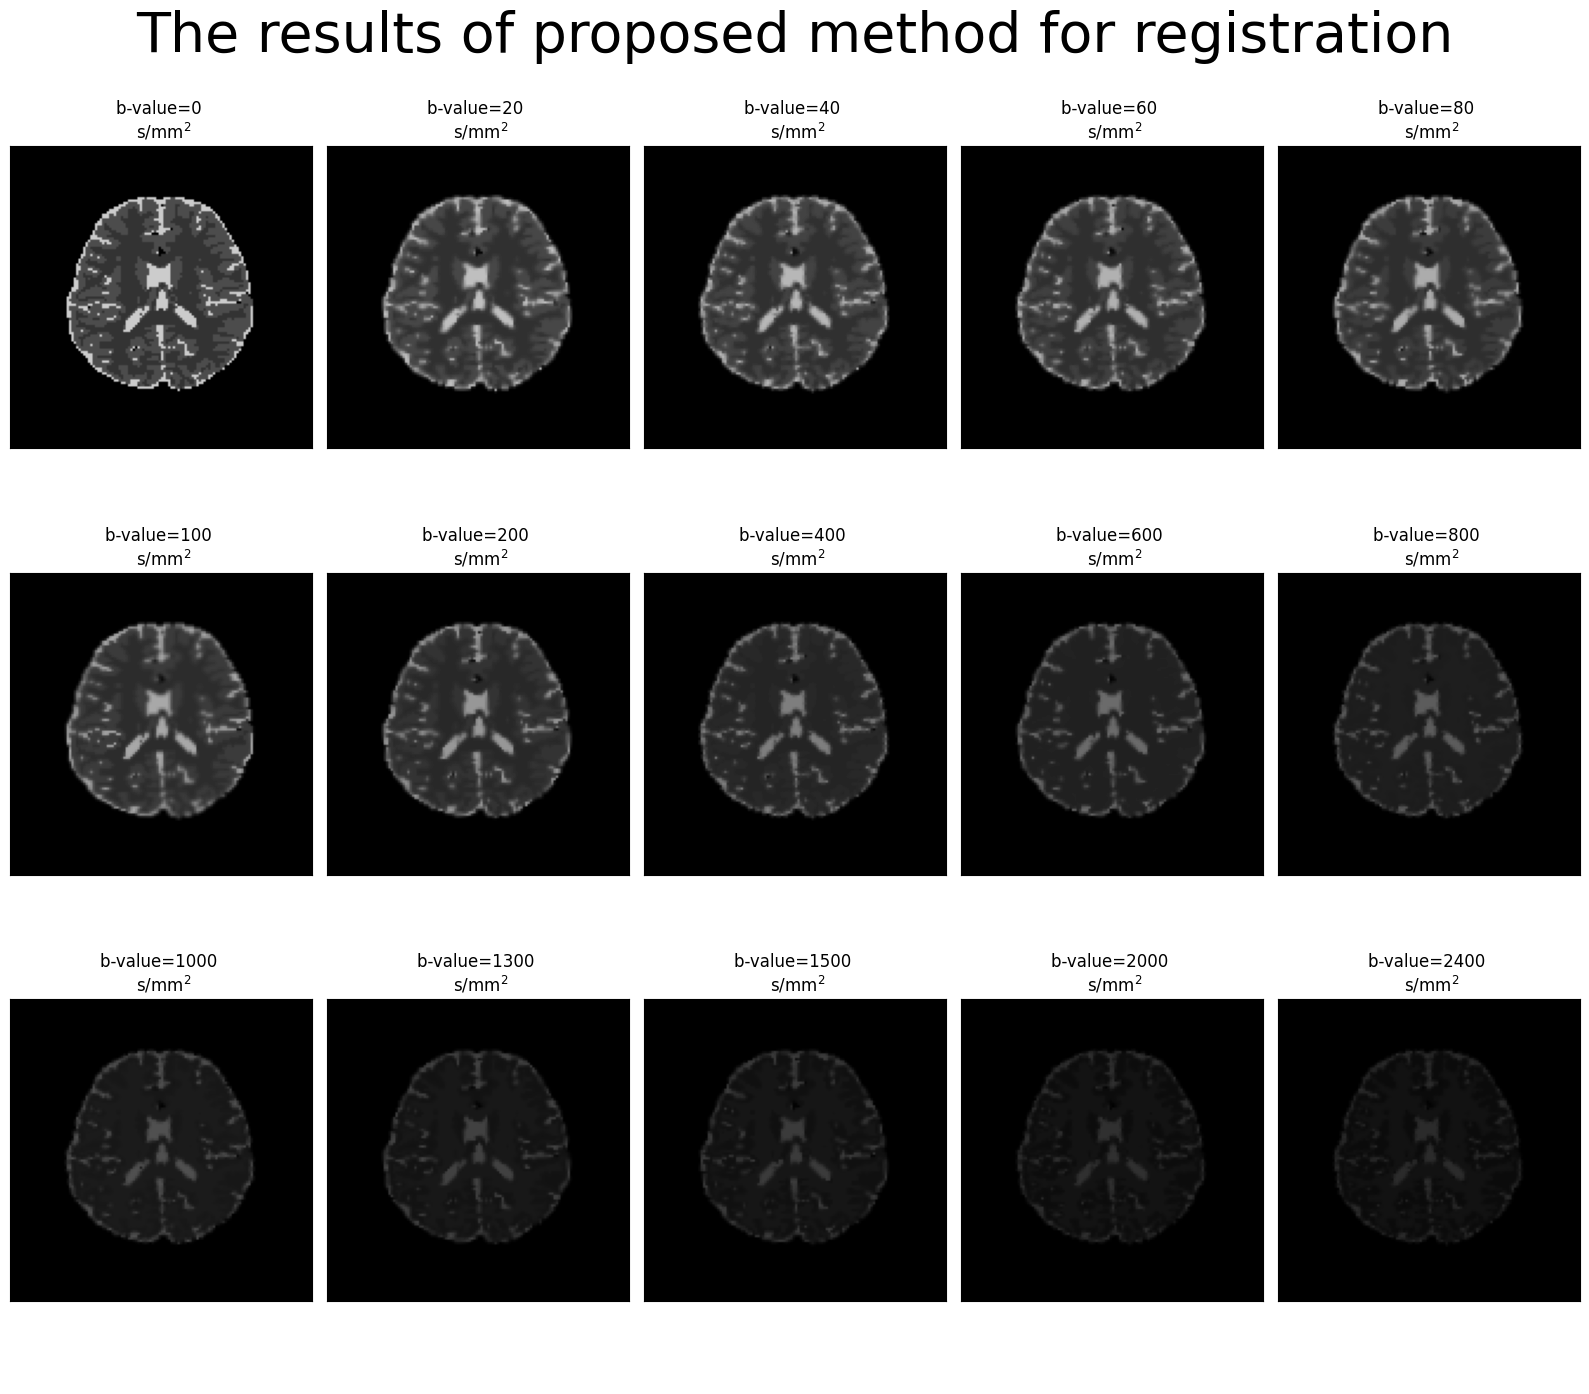

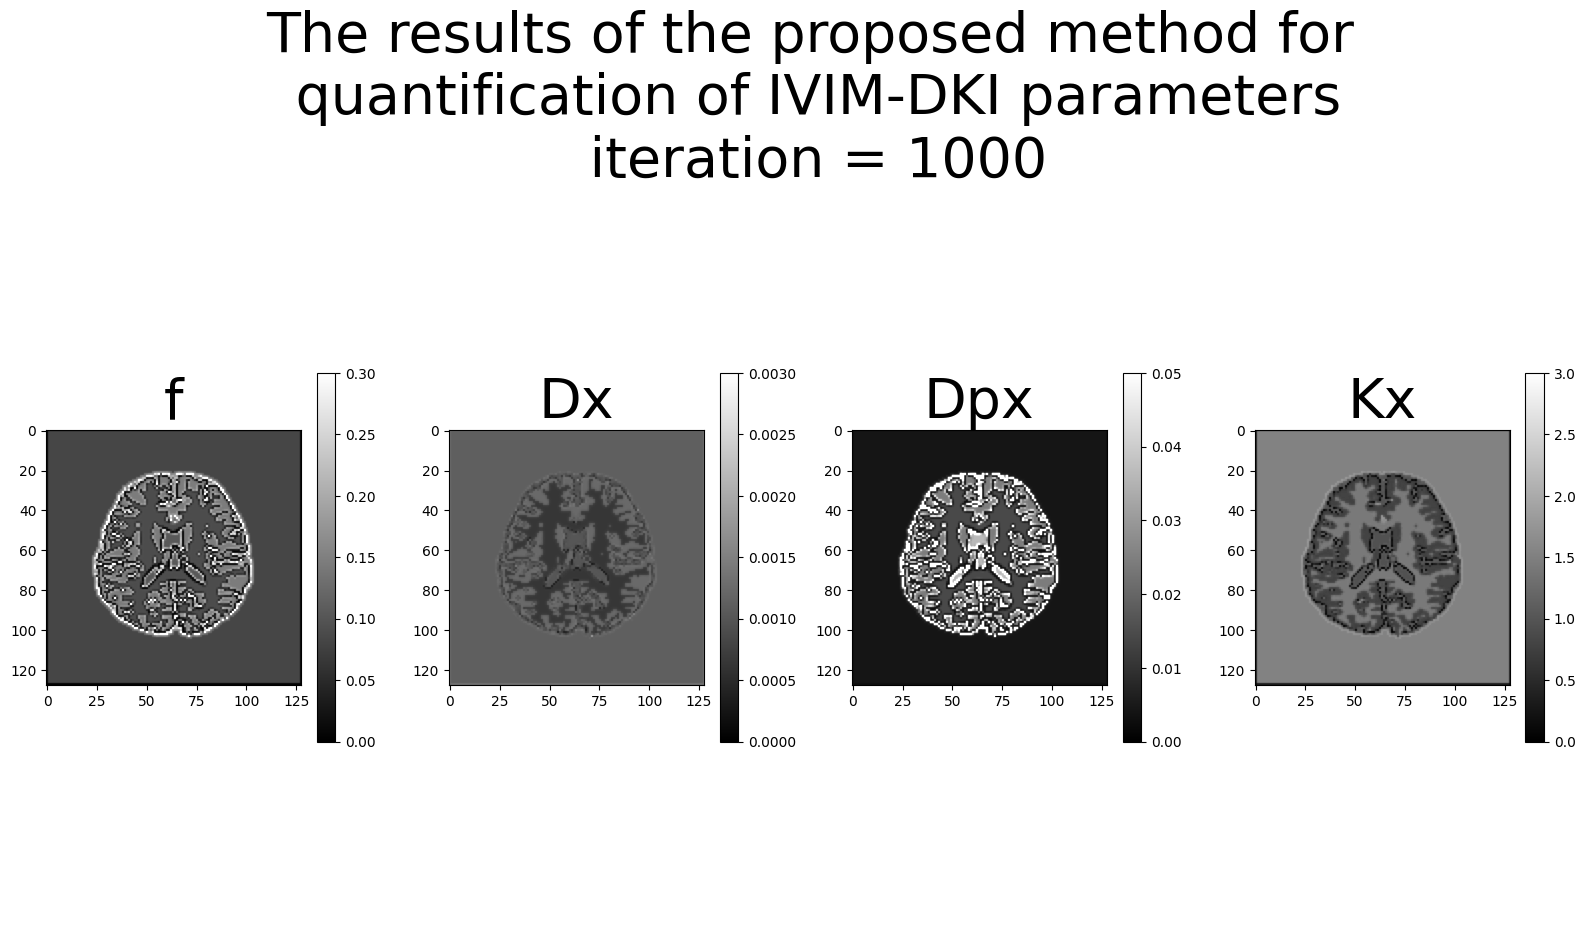

Epochs:  20%|██        | 1201/6000 [01:05<05:11, 15.41it/s]

1200


Epochs:  27%|██▋       | 1601/6000 [01:27<03:41, 19.87it/s]

1600


Epochs:  33%|███▎      | 1999/6000 [01:47<03:31, 18.95it/s]

2000
ncc_loss_io: 0.04911907762289047
loss a: 0.00012477455311454833
total LOSS: 0.17389363050460815 epoch: 2000


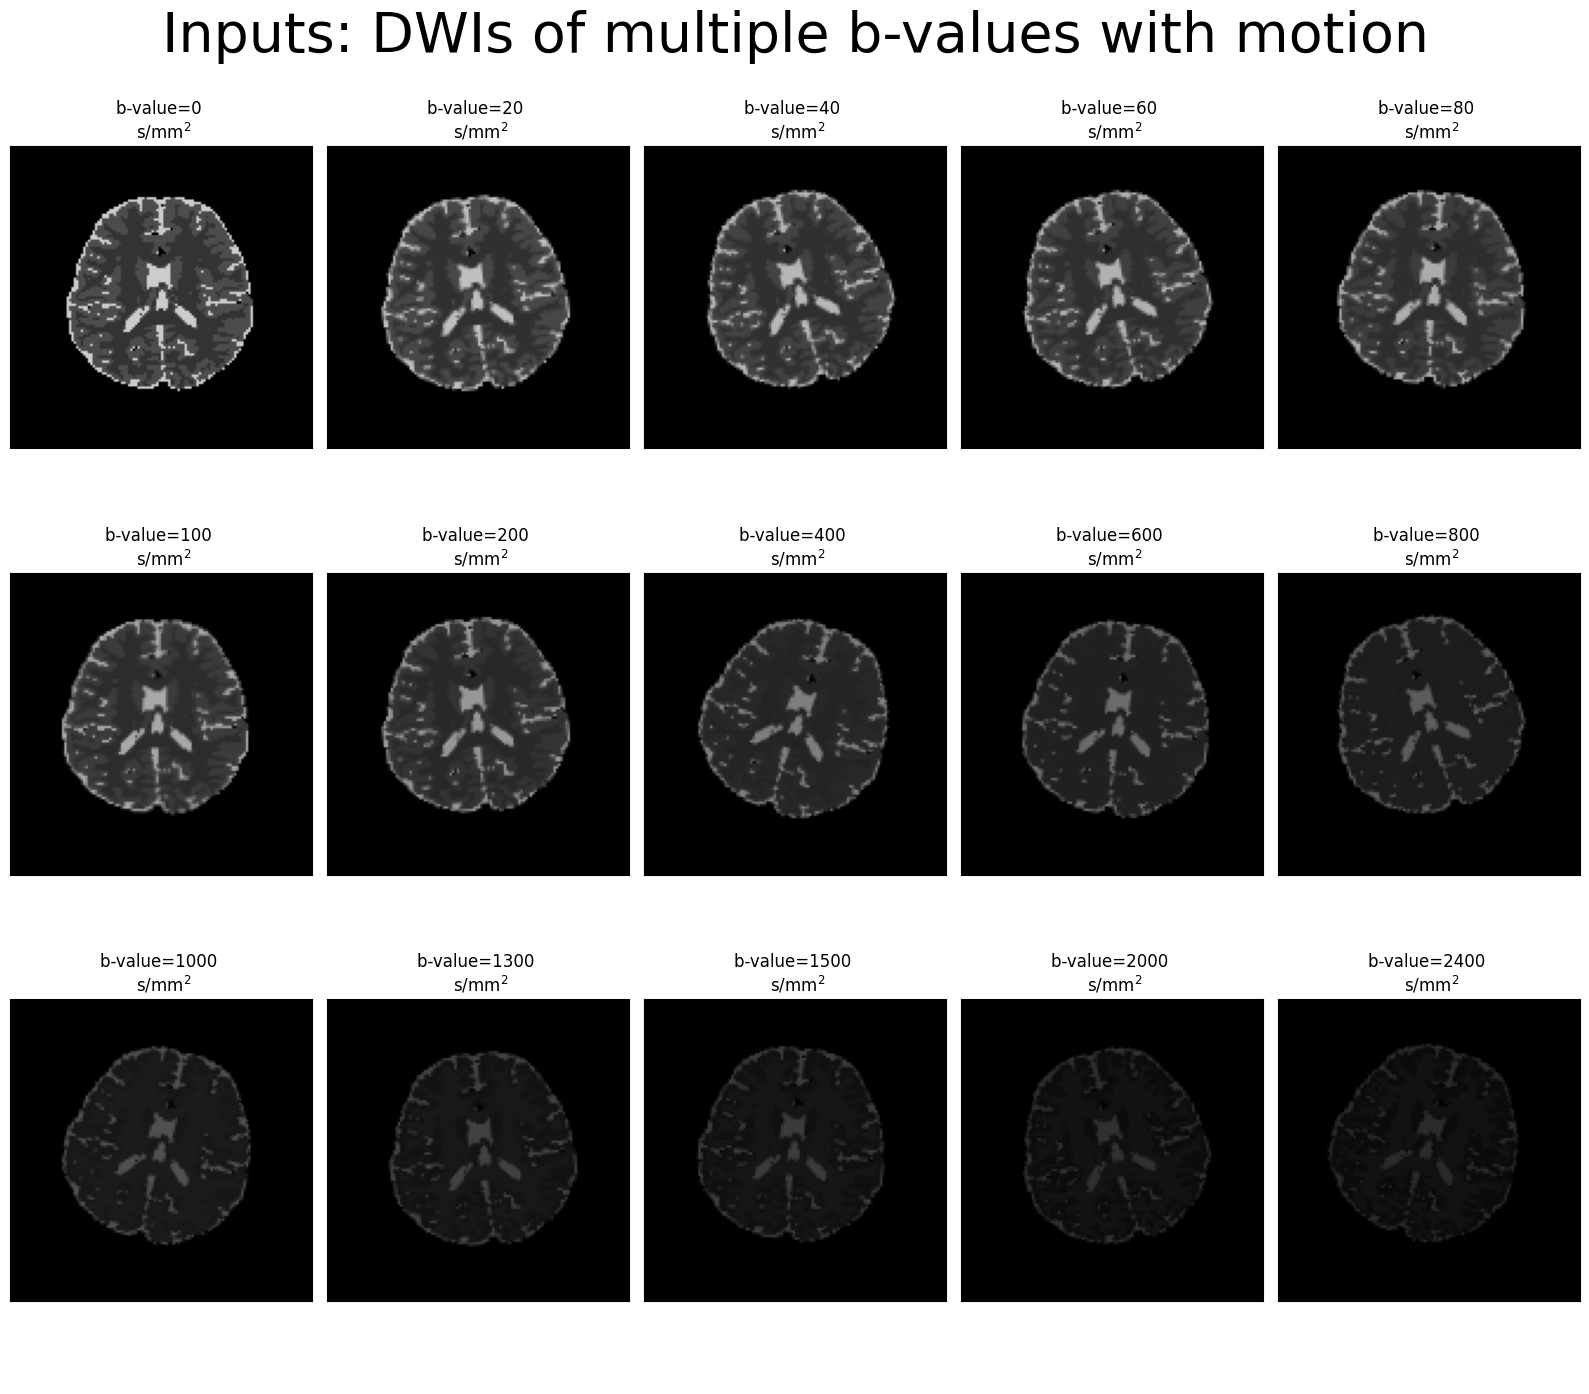

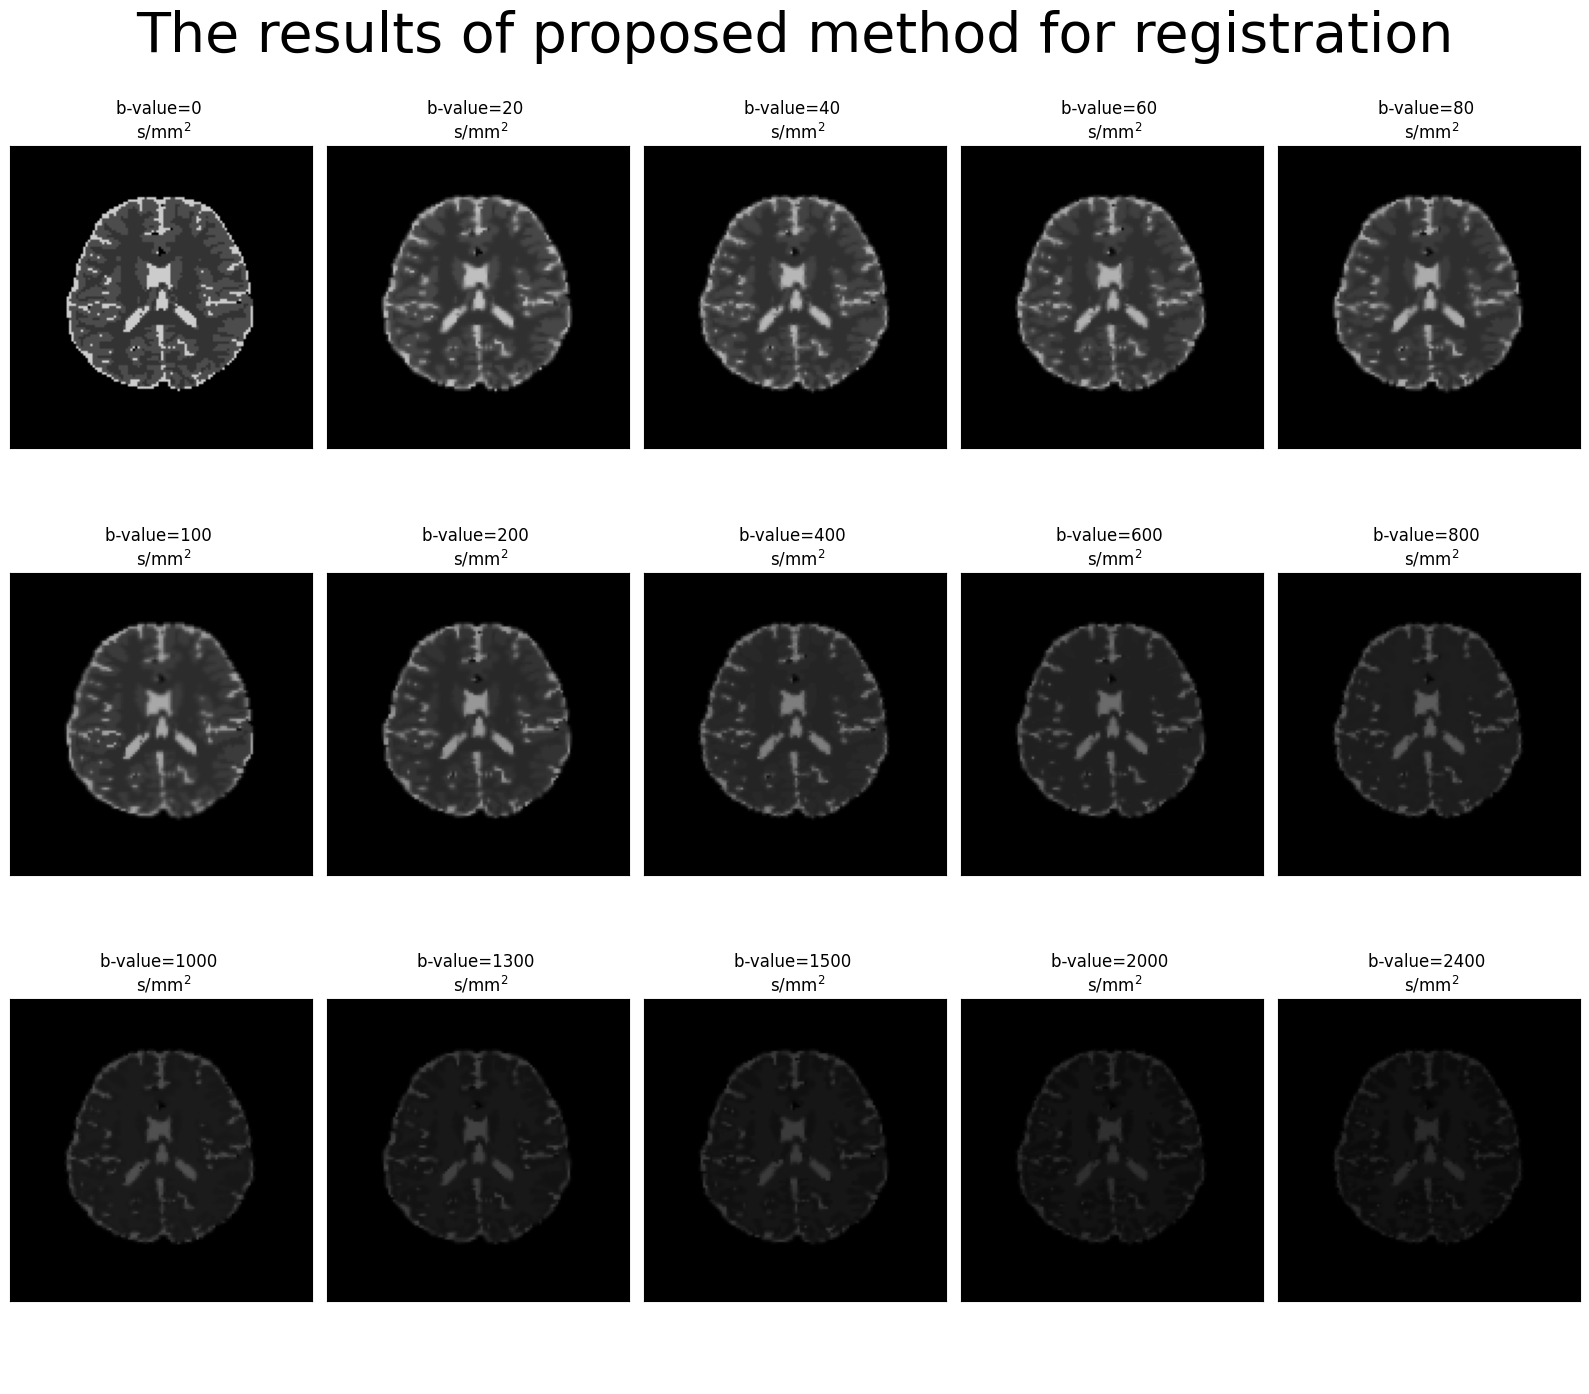

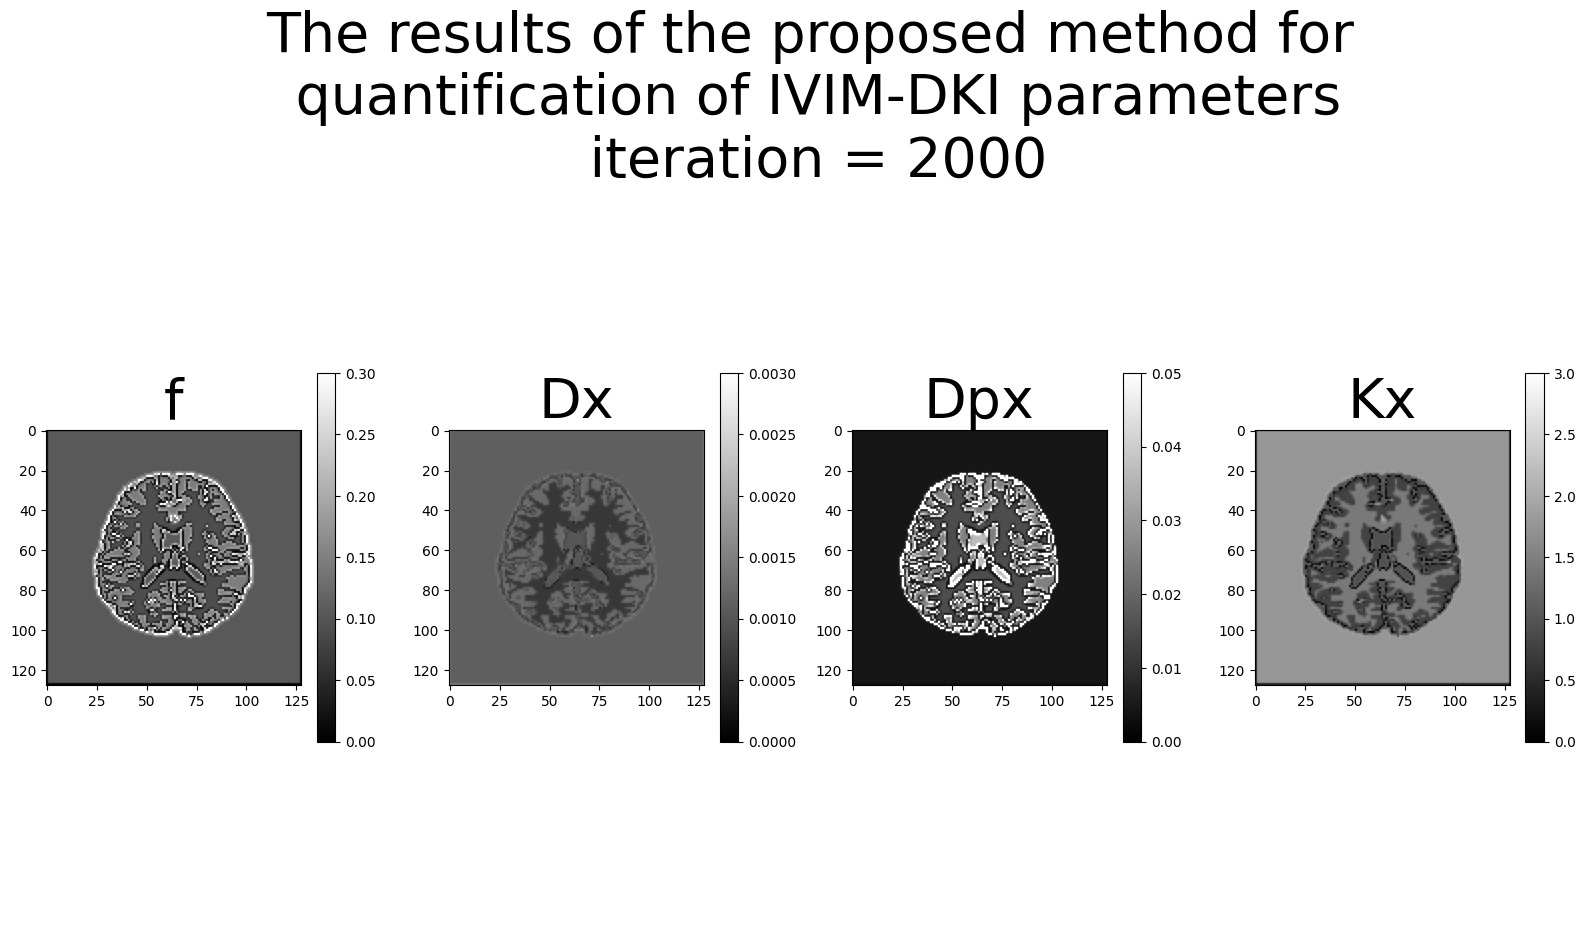

Epochs:  40%|████      | 2402/6000 [02:08<03:18, 18.15it/s]

2400


Epochs:  47%|████▋     | 2800/6000 [02:29<02:25, 21.97it/s]

2800


Epochs:  50%|████▉     | 2999/6000 [02:39<02:23, 20.84it/s]

ncc_loss_io: 0.049717072397470474
loss a: 0.00012393153156153858
total LOSS: 0.12393153458833694 epoch: 3000


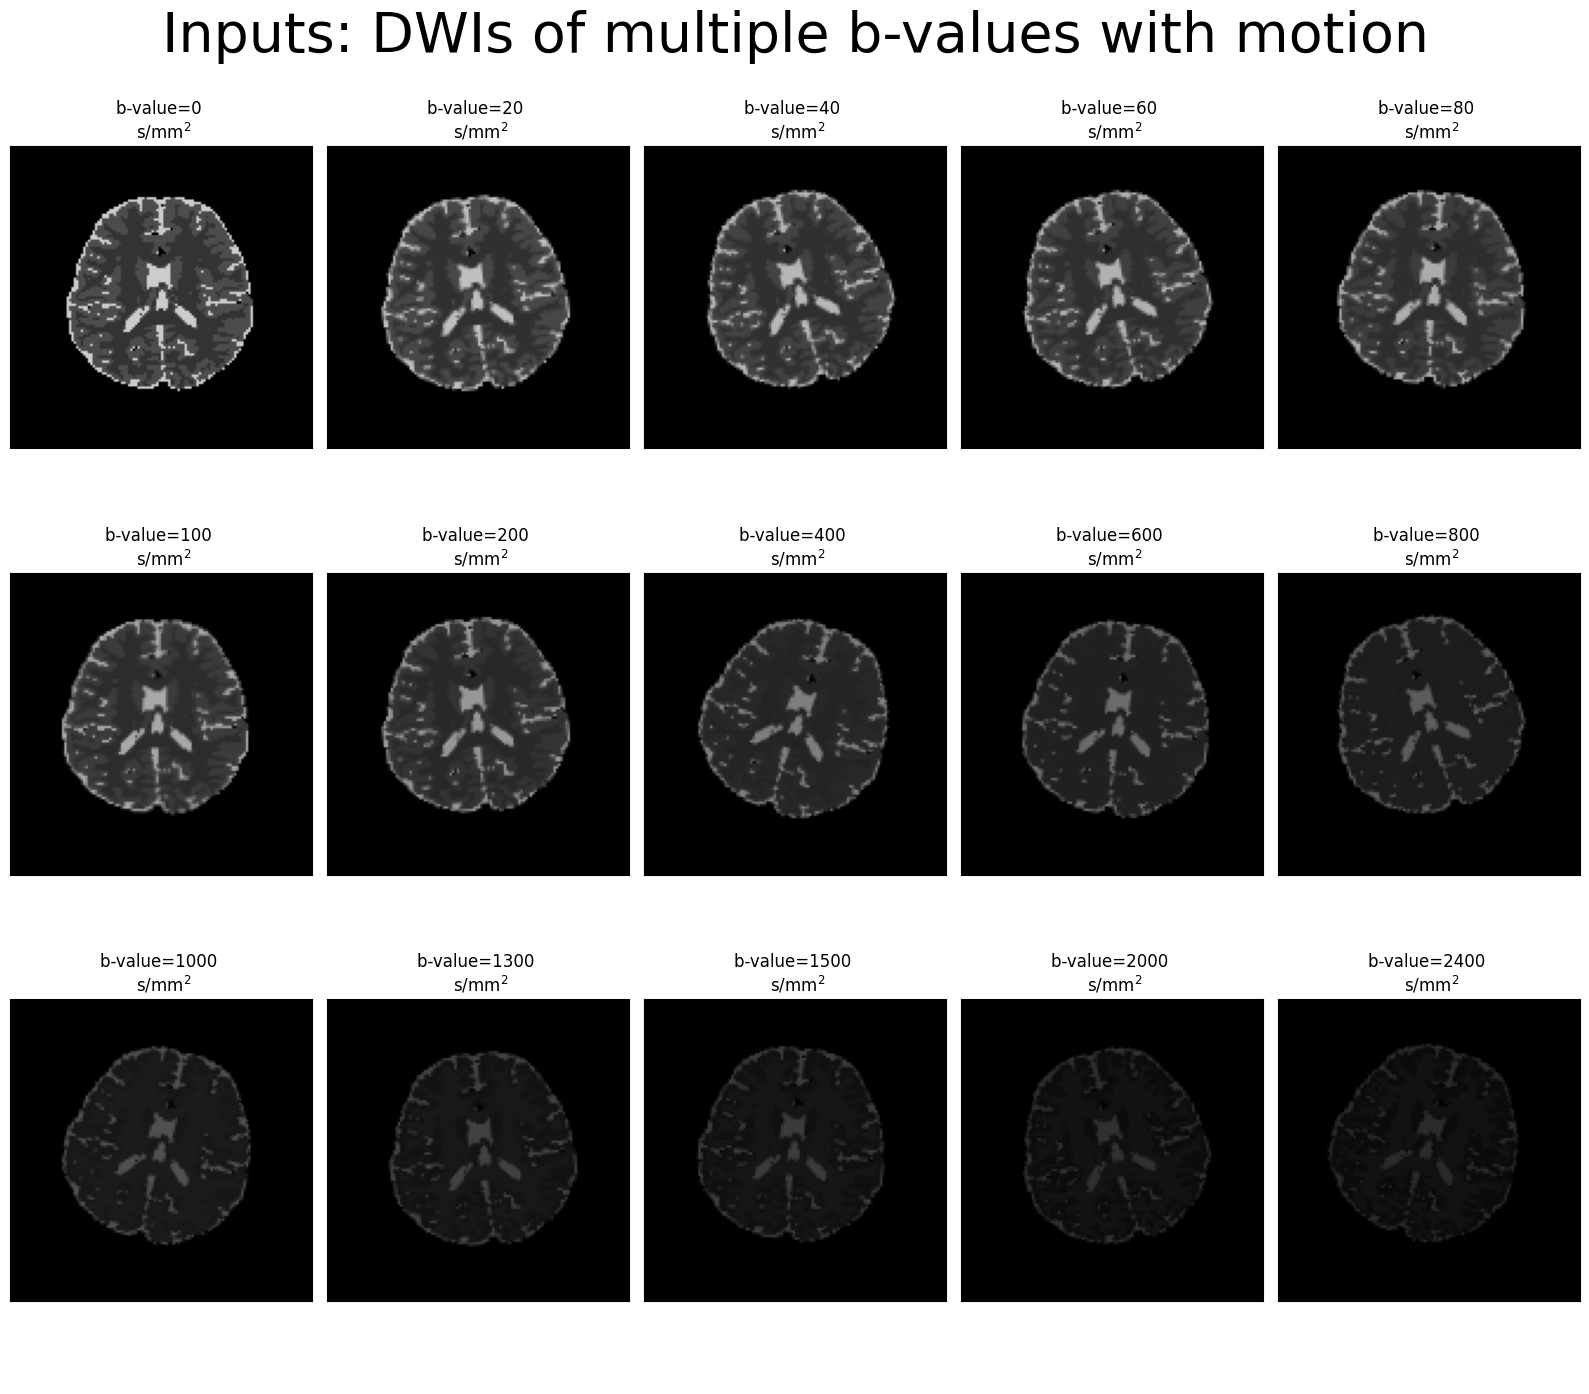

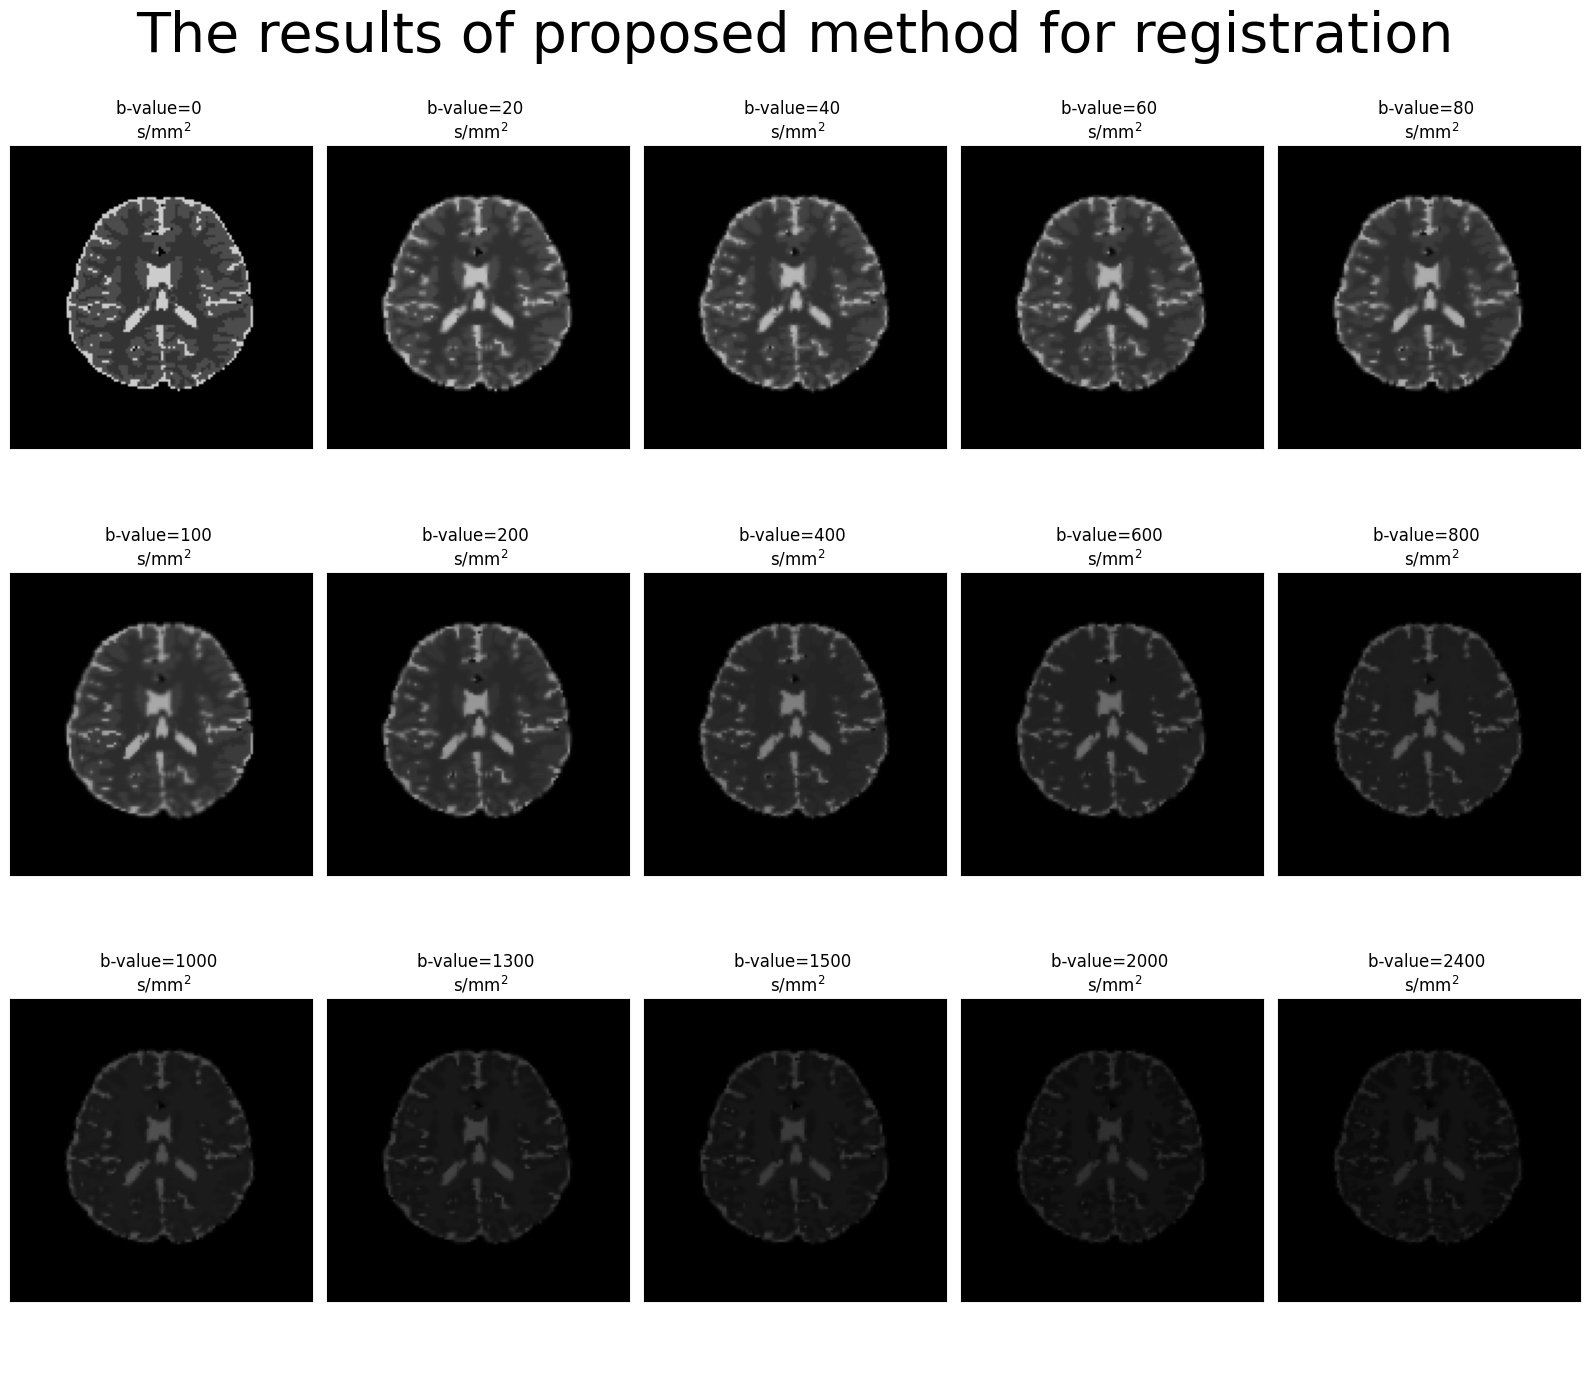

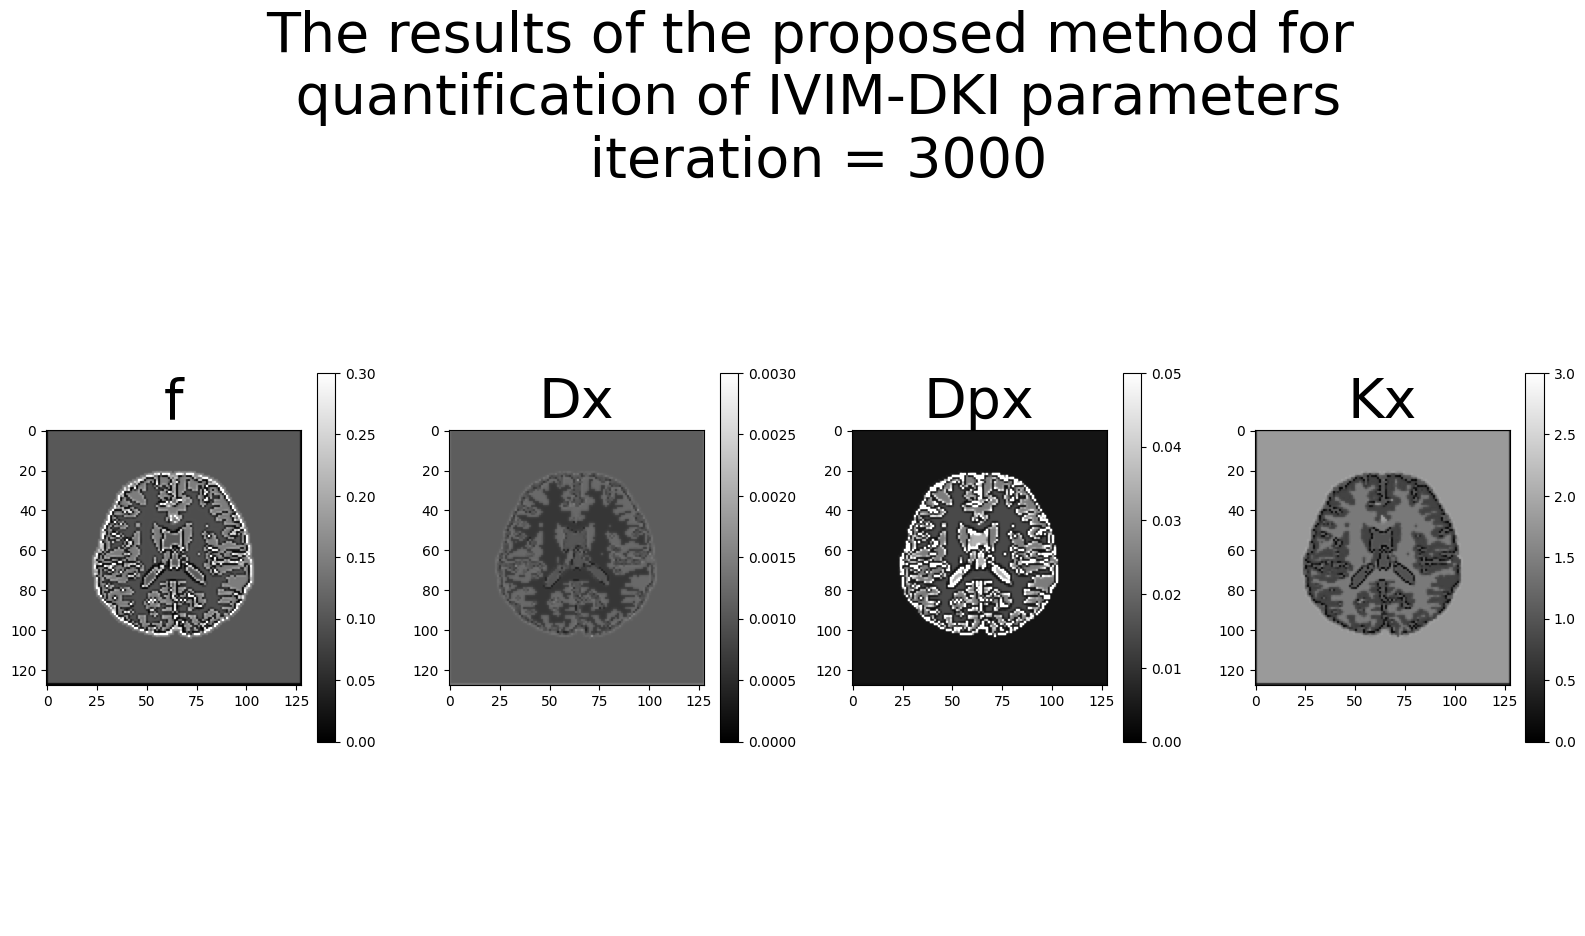

Epochs:  53%|█████▎    | 3205/6000 [02:49<01:57, 23.81it/s]

3200


Epochs:  60%|██████    | 3603/6000 [03:07<01:45, 22.80it/s]

3600


Epochs:  67%|██████▋   | 3999/6000 [03:23<01:38, 20.42it/s]

4000
ncc_loss_io: 0.0834680125117302
loss a: 0.00011103740689577535
total LOSS: 0.11103740334510803 epoch: 4000


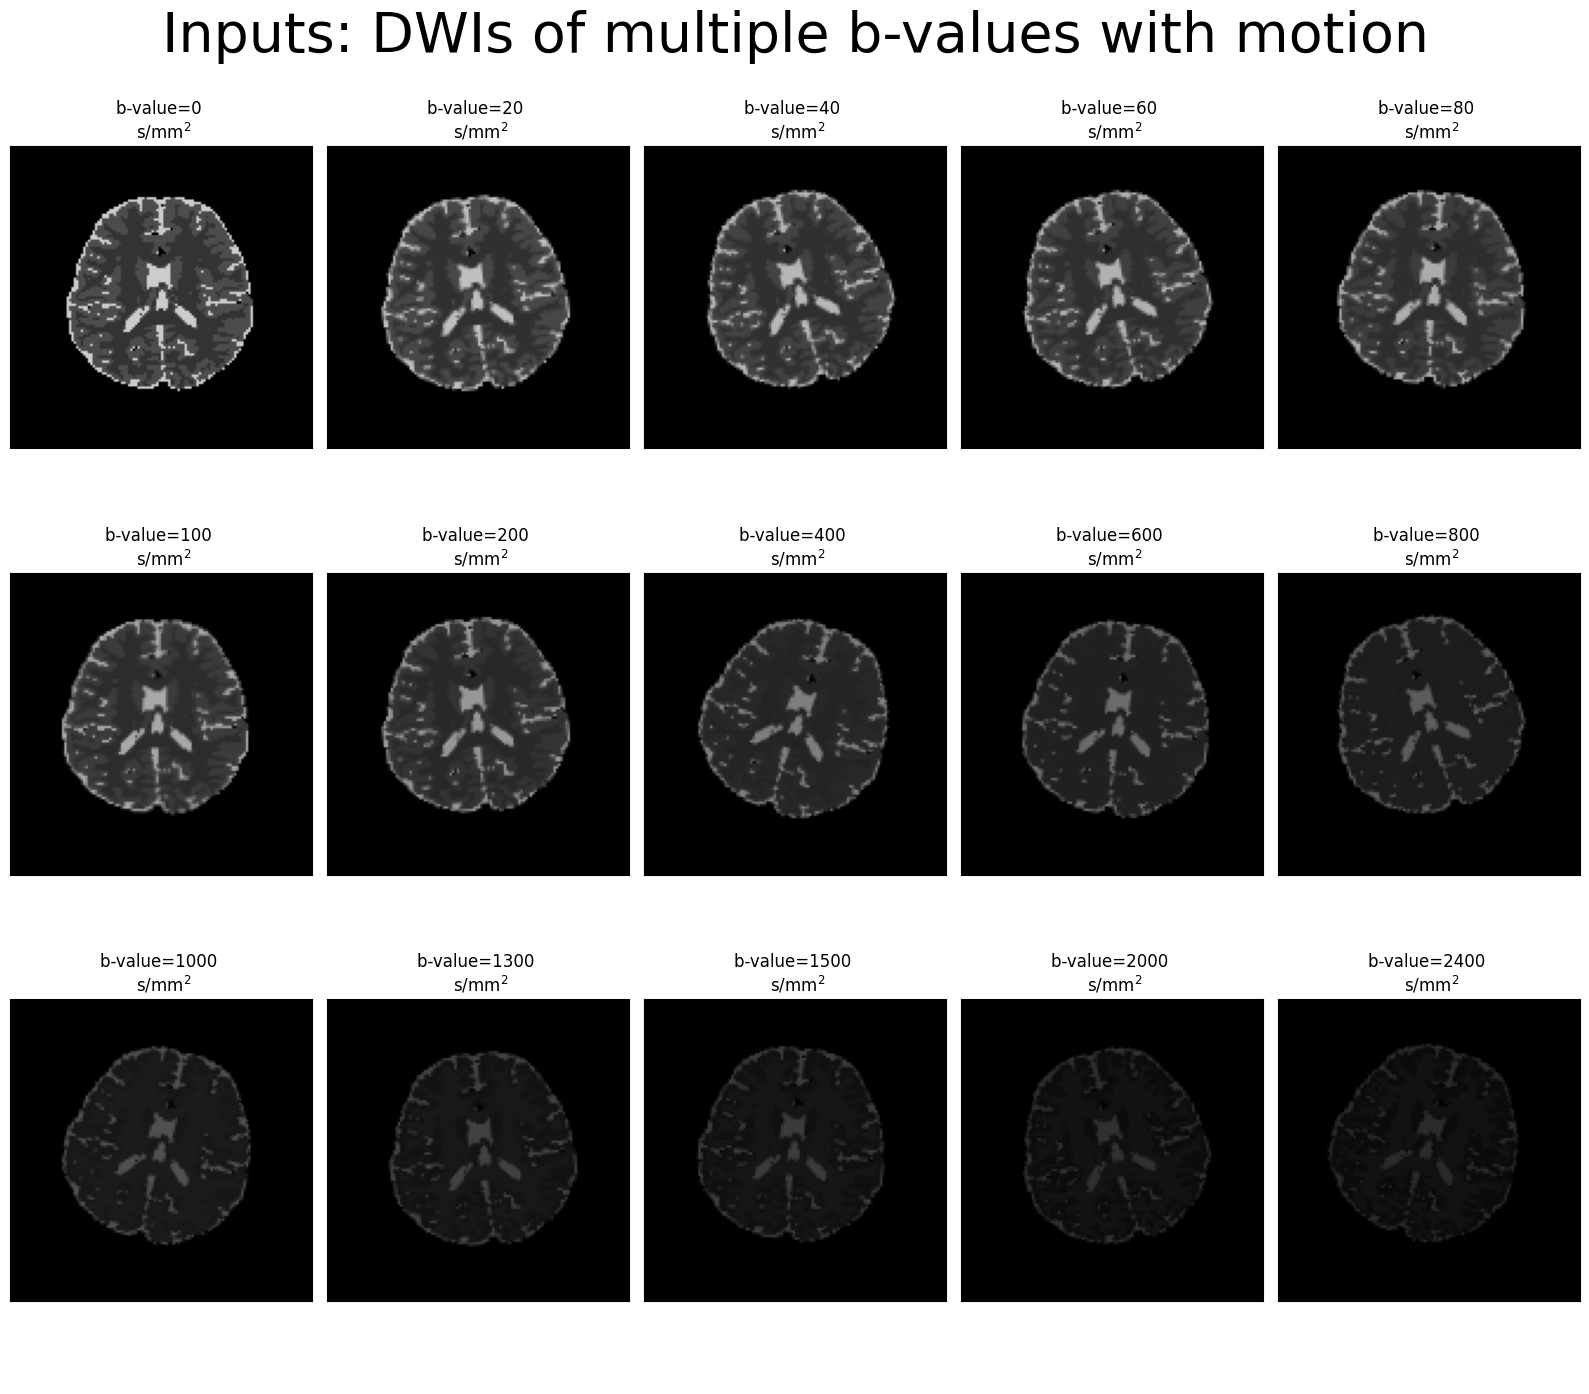

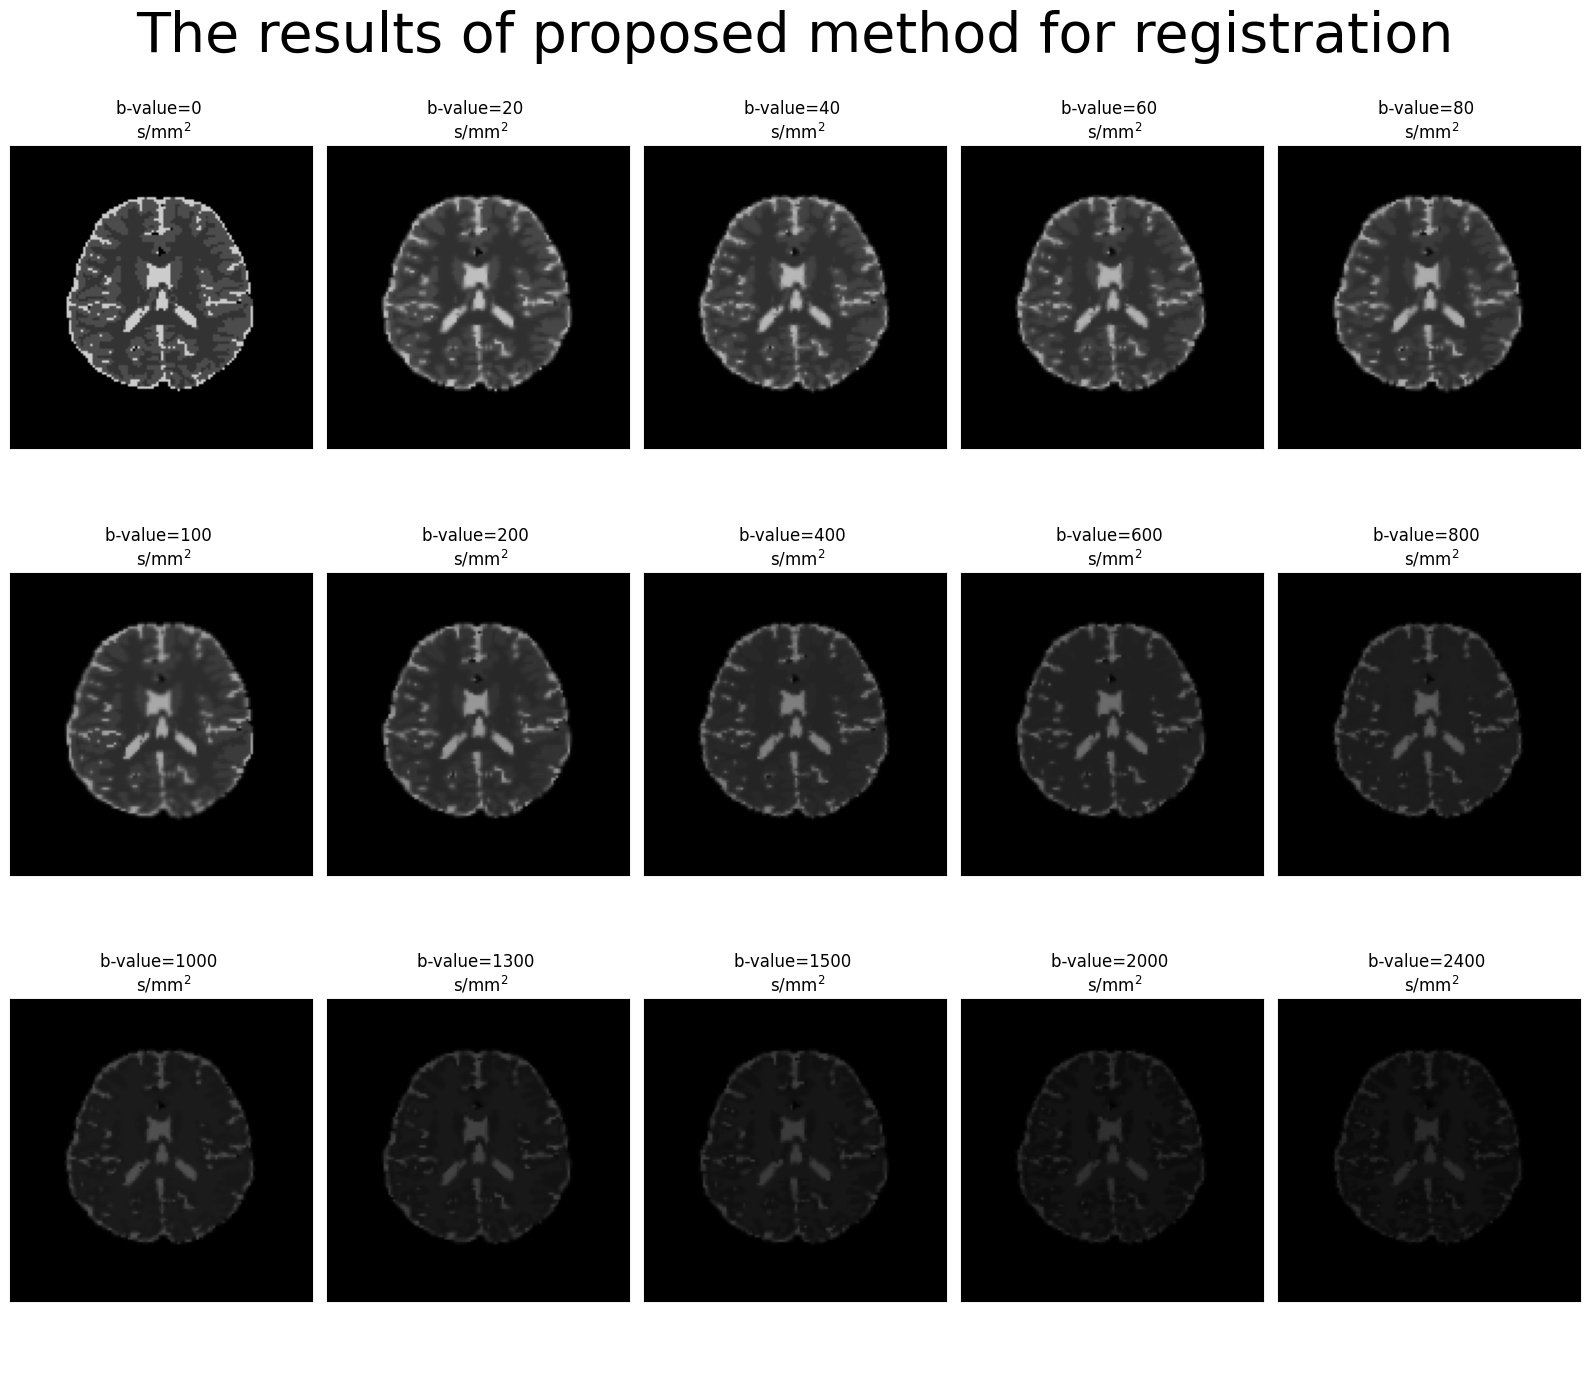

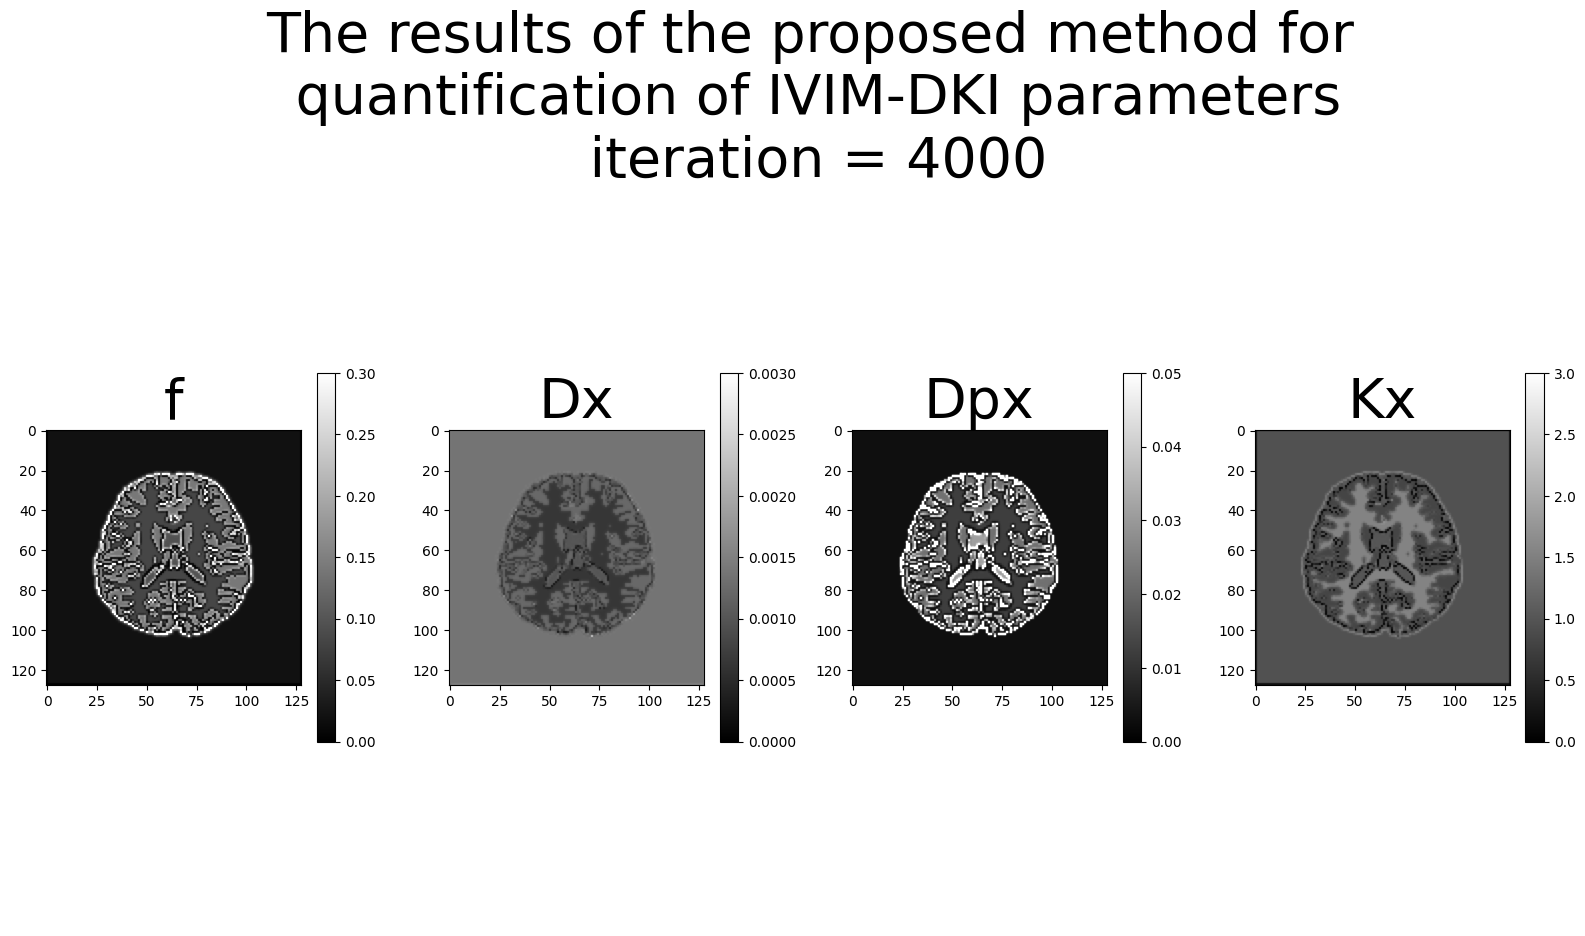

Epochs:  73%|███████▎  | 4403/6000 [03:40<00:50, 31.72it/s]

4400


Epochs:  80%|████████  | 4803/6000 [03:57<00:46, 25.74it/s]

4800


Epochs:  83%|████████▎ | 4998/6000 [04:05<00:41, 23.97it/s]

ncc_loss_io: 0.08354785293340683
loss a: 0.00011098753020633012
total LOSS: 0.11098752915859222 epoch: 5000


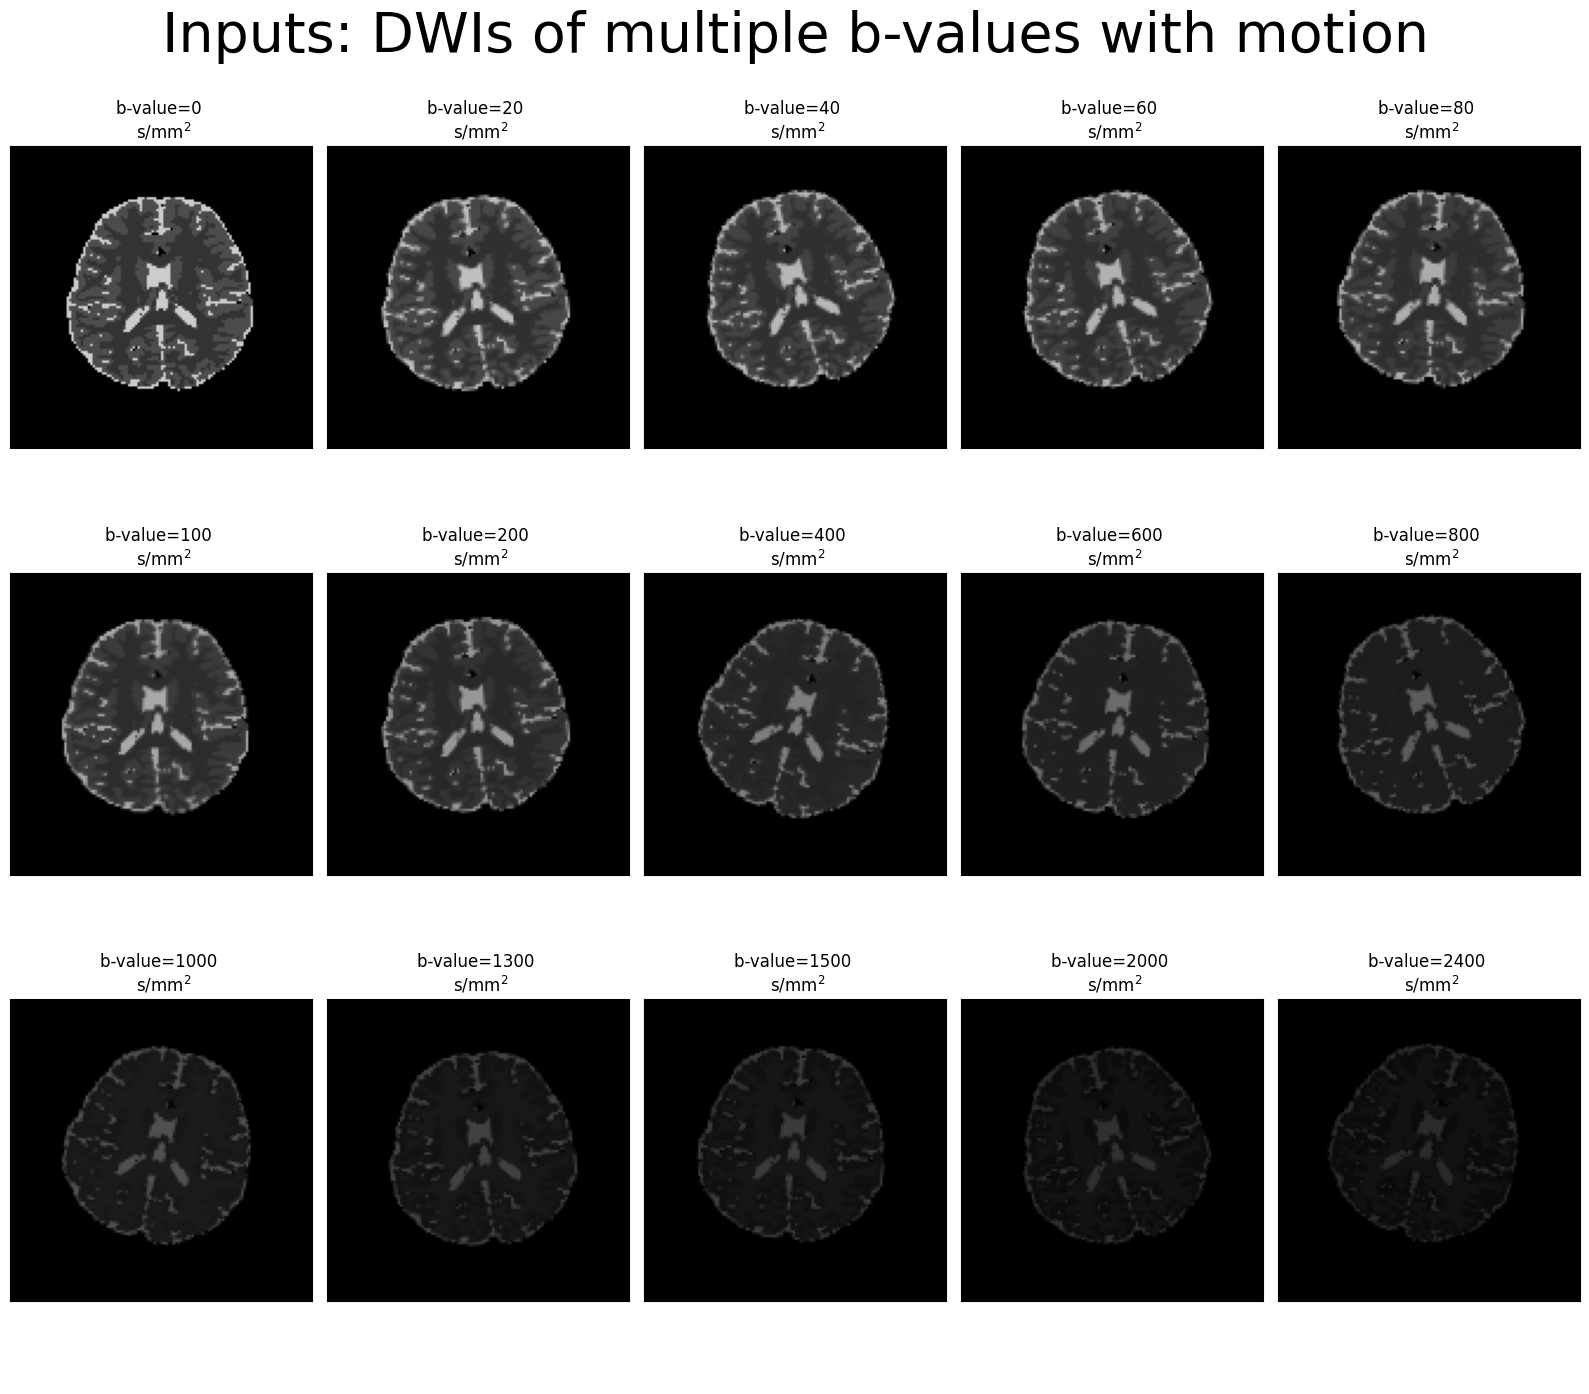

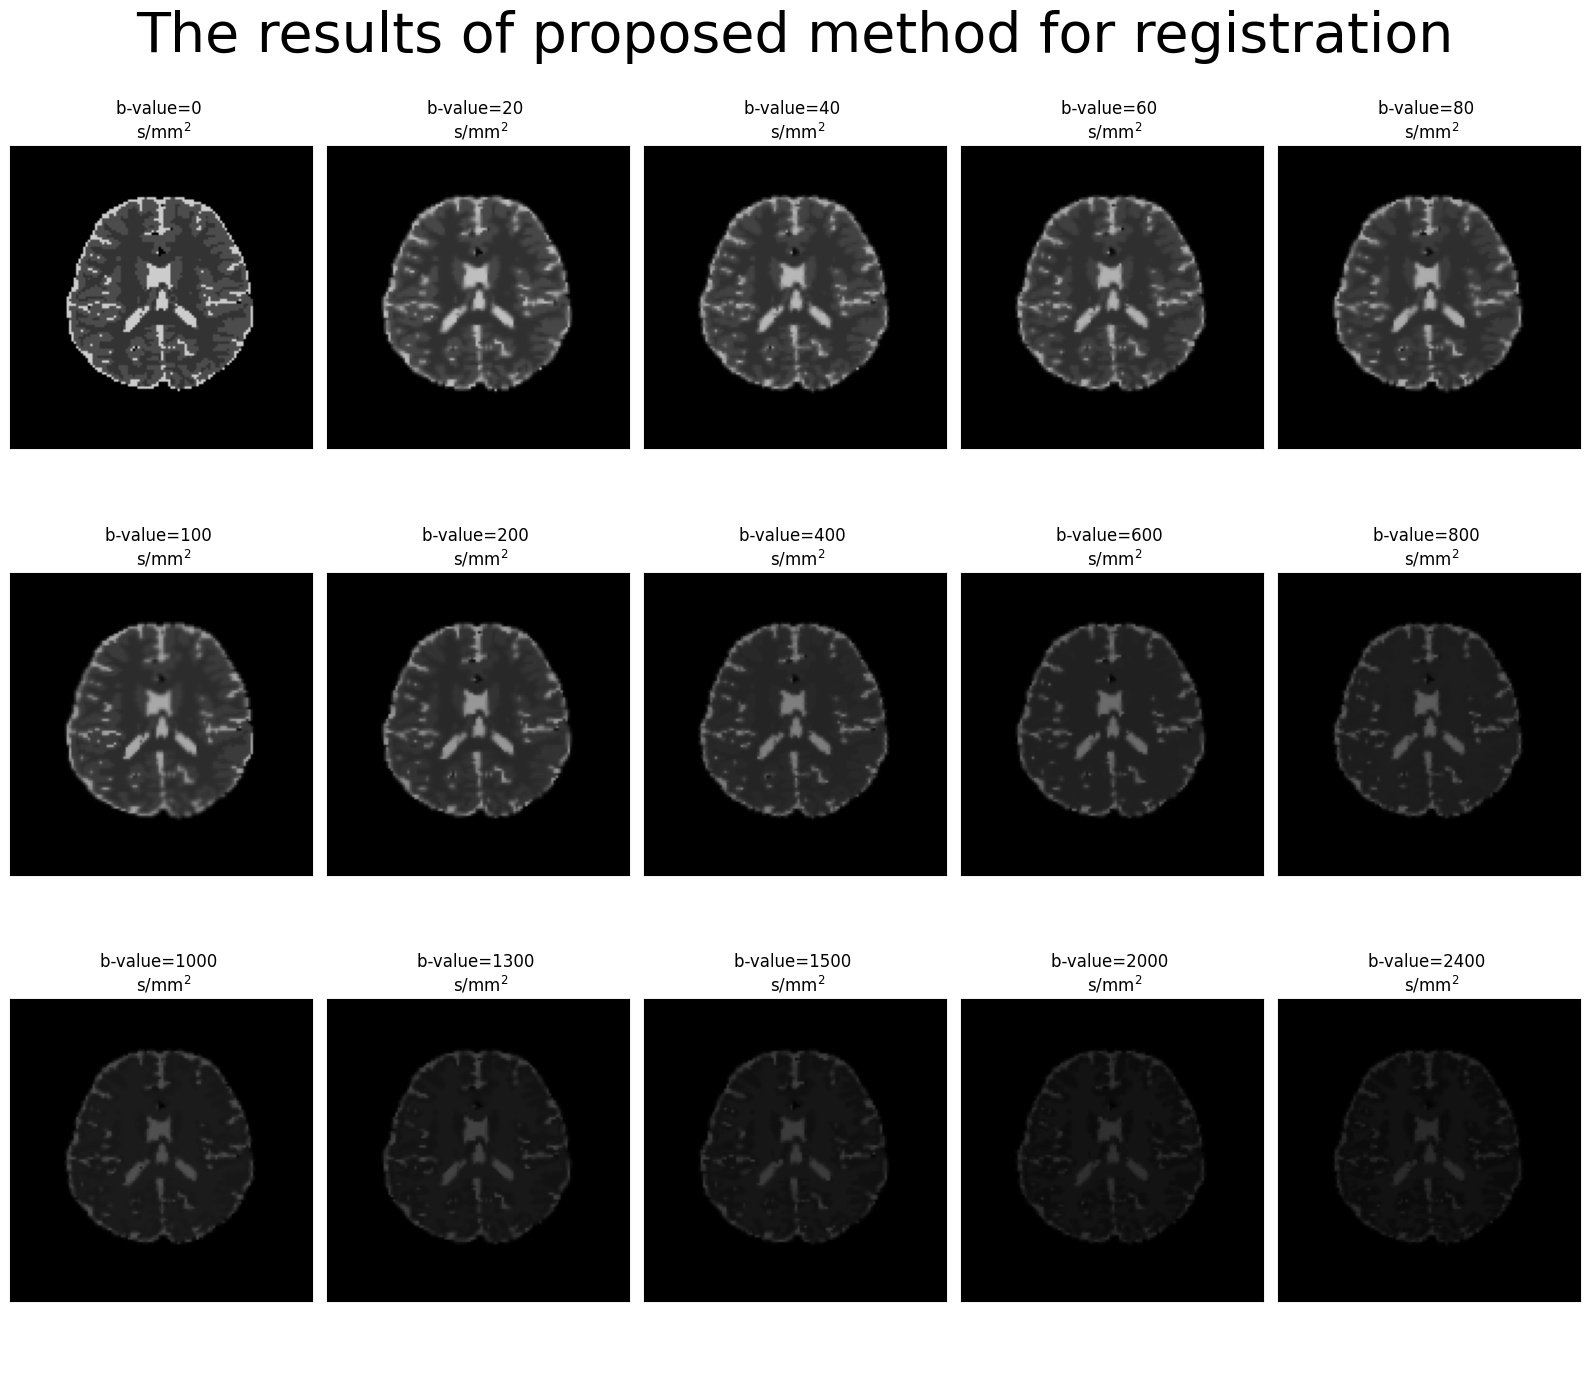

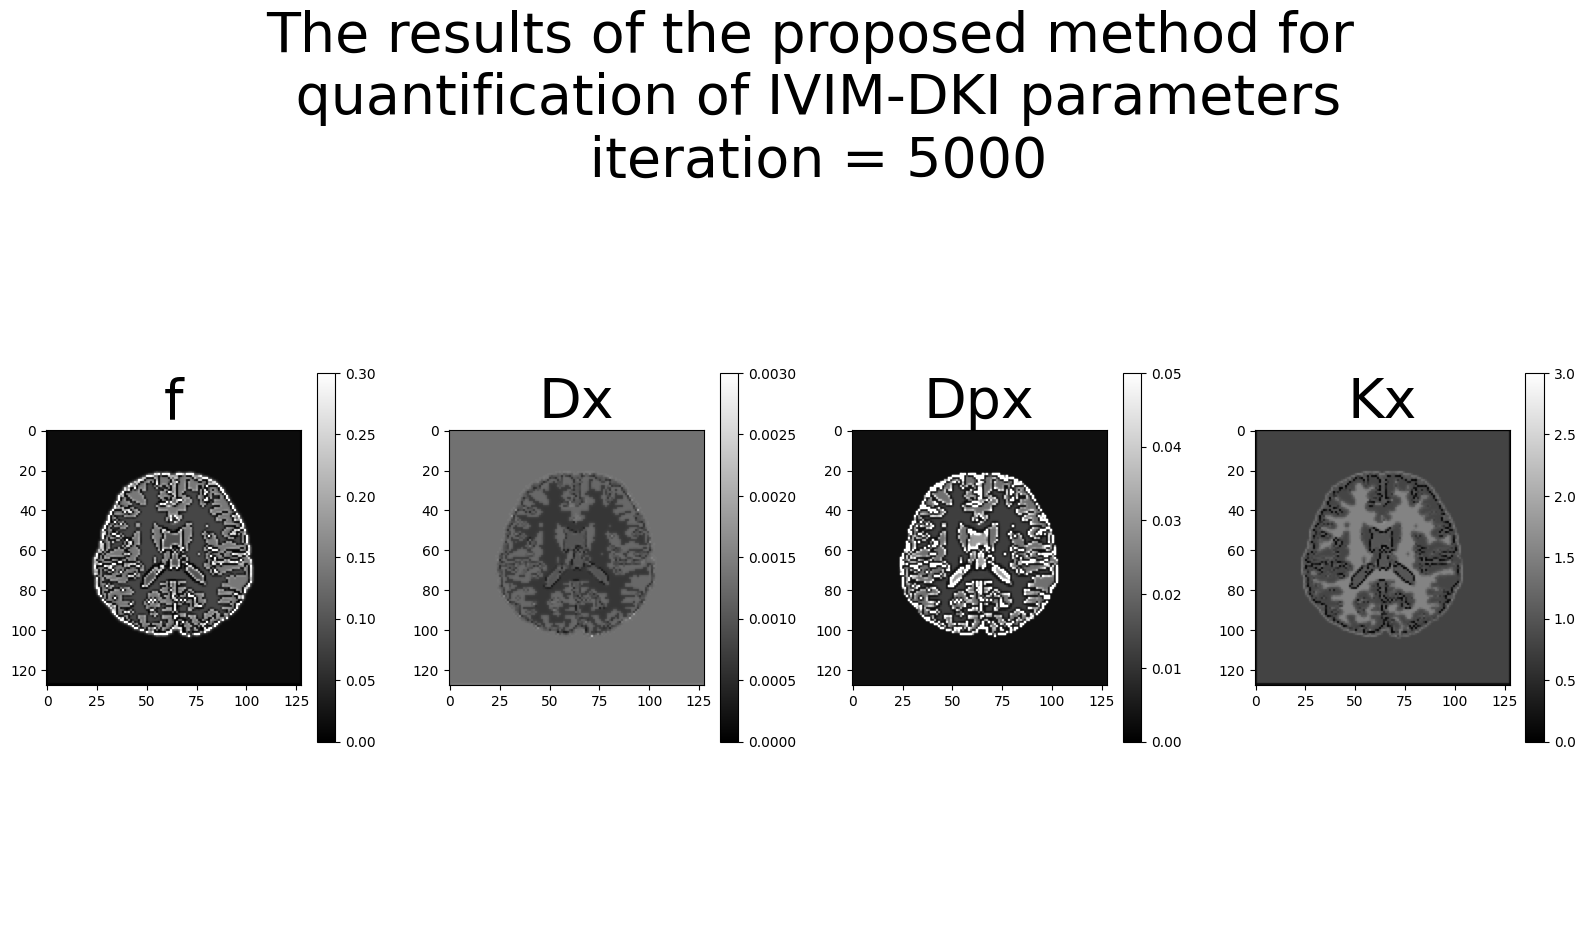

Epochs:  87%|████████▋ | 5202/6000 [04:14<00:29, 26.66it/s]

5200


Epochs:  93%|█████████▎| 5604/6000 [04:30<00:15, 24.81it/s]

5600


Epochs: 100%|██████████| 6000/6000 [04:46<00:00, 20.95it/s]


In [9]:
checkpoint = torch.load(
    'trained_model.pth',
    map_location=f'cuda:{GPU_NUM}')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
quant_optimizer.load_state_dict(checkpoint['quant_optimizer_state_dict'])
trained_loss = checkpoint['train_loss']


epochs = tqdm(range(num_epochs_test), desc="Epochs")
test_loss=[]
test_signal_loss=[]
for epoch in epochs:
    if epoch % 400 == 0:
        print(epoch)
    test_batch_loss = []
    test_signal_batch_loss = []
    test_ncc_batch_loss = []

    test_batch_loss = []
    test_signal_batch_loss = []
    test_ncc_batch_loss = []

    for iteration, batch in enumerate(testloader):
        S0 = batch[0][:,0,:,:]
        h=batch[0].size(2)
        w=batch[0].size(3)
        mask_test = batch[1]

        motion_mask = mask_test.to(device)
        motion_mask = motion_mask.view(-1,num_bvalue,h,w)

        S0_mask = mask_test[:,0,:,:].view(-1,1,h,w).to(device)
        S0 = S0.view(-1,1,h,w).to(device) * S0_mask
        S0_mask_repeat = S0_mask.repeat(1,num_bvalue,1,1).to(device)

        S_input_n = batch[0]/1000
        S_input_n[torch.isnan(S_input_n)] = 0
        S_input_n[torch.isinf(S_input_n)] = 0
        S_input_n = S_input_n.to(device)
        S_input_n = S_input_n.view(-1,num_bvalue,h,w)

        S_input_n_original = batch[2]/1000
        S_input_n_original[torch.isnan(S_input_n_original)] = 0
        S_input_n_original[torch.isinf(S_input_n_original)] = 0
        S_input_n_original = S_input_n_original.to(device)
        S_input_n_original = S_input_n_original.view(-1,num_bvalue,h,w)

        # STN + DNN
        IVIM_map_x, fxyz, theta, rot_S_b1, rot_S_b1_masked = model(S_input_n,  S0_mask_repeat)

        # f = fxyz[:, 0, :, :].view(-1, 1, h, w)*(fmax-fmin)+fmin
        f = IVIM_map_x[:, 3, :, :].view(-1, 1, h, w)*(fmax-fmin)+fmin

        Dx = IVIM_map_x[:, 0, :, :].view(-1, 1, h, w)*(Dmax-Dmin)+Dmin
        Dpx = IVIM_map_x[:, 1, :, :].view(-1, 1, h, w)*(Dpmax-Dpmin)+Dpmin
        Kx = IVIM_map_x[:, 2, :, :].view(-1, 1, h, w)*(Kmax-Kmin)+Kmin

        #Biexponential model
        S_estimate_x = S0 * (f * torch.exp(-b * Dpx) + (1 - f) * torch.exp(-b * Dx + 1/6*(b**2)*(Dx**2)*Kx)) / 1000
        S_estimate_x = S_estimate_x.view([-1, num_bvalue, h, w])
        mask_fixed_test = S0_mask_repeat.view(-1,num_bvalue, h, w)

        #Inverse STN 
        S_estimate_inverse, inv_theta = inv_stn(S_estimate_x[:,1:,:,:], theta, device)
        S_estimate_x = torch.cat((S_input_n[:,0,:,:].view(-1,1,h, w), S_estimate_x[:,1:,:,:]), 1)

        S_estimate_inverse = S_estimate_inverse.view(-1,(num_bvalue-1),h, w)
        S_estimate_inverse = torch.cat((S_input_n[:,0,:,:].view(-1,1,h,w), S_estimate_inverse), 1)


        #LOSS1: Signal LOSS
        Signal_loss = criterion(S_input_n, S_estimate_inverse)

        #LOSS2: NMI LOSS
        # ncc_loss = 0
        # for bi in range(1, 3*(num_bvalue-1)+1):
        #     ncc_loss += -torch.log((normalized_cross_correlation(S_input_n[:,0,:,:], rot_S_b1[:,bi,:,:],False)+1)/2)

        #LOSS3: NCC LOSS
        ncc_loss_io = 0
        for bi in range(1, num_bvalue):
            ncc_loss_io += -torch.log((normalized_cross_correlation(S_input_n[:,bi,:,:], S_estimate_inverse[:,bi,:,:],False)+1)/2)


        if epoch < num_epochs_test/2:
            loss = ncc_loss_io + criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)*1000
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        else:
            loss = criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)*1000
            quant_optimizer.zero_grad()
            loss.backward(retain_graph=True)
            quant_optimizer.step()

        test_batch_loss.append(loss.item())
        test_signal_batch_loss.append(Signal_loss.item())

        if epoch % 1000 == 0 and iteration == 0:
            print(f"ncc_loss_io: {ncc_loss_io}")
            print(f"loss a: {criterion(rot_S_b1*S0_mask_repeat, S_estimate_x*S0_mask_repeat)}")
            print(f"total LOSS: {loss} epoch: {epoch}")
            # plt.plot(test_loss) # plot for test data loss over iterations
        
            plt.figure(figsize=(16,14))
            plt.xticks([])
            plt.yticks([])
            plt.box(None)
            b_value = [0, 20,40,60,80,100,200,400,600,800,1000,1300,1500,2000,2400]
            plt.title('Inputs: DWIs of multiple b-values with motion',fontsize=40)
            for i in range(15):
                plt.subplot(3,5,i+1)
                plt.title('b-value='+str(b_value[i])+' \n s/mm$^{2}$')
                plt.imshow(S_input_n[0,i,:,:].detach().cpu(),vmin=0,vmax=1,cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(16,14))
            plt.xticks([])
            plt.yticks([])
            plt.box(None)
            plt.title('The results of proposed method for registration',fontsize=40)
            for i in range(15):
                plt.subplot(3,5,i+1)
                plt.title('b-value='+str(b_value[i])+' \n s/mm$^{2}$')
                plt.imshow(rot_S_b1[0,i,:,:].detach().cpu(),vmin=0,vmax=1,cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(16,8))
            plt.tight_layout()
            plt.title('The results of the proposed method for\n quantification of IVIM-DKI parameters\n iteration = '+ str(epoch), fontsize = 40)
            plt.xticks([])
            plt.yticks([])
            plt.box(None)
            plt.subplot(1,4,1)
            plt.title('f', fontsize = 40)
            plt.imshow(f[0,0,:,:].detach().cpu(),vmin=0,vmax=0.3,cmap='gray')
            plt.colorbar(shrink=0.5)
            plt.subplot(1,4,2)
            plt.title('Dx', fontsize = 40)
            plt.imshow(Dx[0,0,:,:].detach().cpu(),vmin=0,vmax=3e-3,cmap='gray')
            plt.colorbar(shrink=0.5)
            plt.subplot(1,4,3)
            plt.title('Dpx', fontsize = 40)
            plt.imshow(Dpx[0,0,:,:].detach().cpu(),vmin=0,vmax=50e-3,cmap='gray')
            plt.colorbar(shrink=0.5)
            plt.subplot(1,4,4)
            plt.title('Kx', fontsize = 40)
            plt.imshow(Kx[0,0,:,:].detach().cpu(),vmin=0,vmax=3,cmap='gray')
            plt.colorbar(shrink=0.5)
            plt.tight_layout()
            plt.show()

    test_loss.append(np.mean(test_batch_loss))
    test_signal_loss.append(np.mean(test_signal_batch_loss))